## Problema de negócio

O cfo da empresa fez uma reunião com todos os gerentes de loja e pediu para que cada um dele trouxesse uma previsão diária das próximas 6 semanas de vendas.
Cada gerente entrou em contato com você para requisitar a previsão de vendas.

A motivação.
- Qual o contexto?
Reunião de resultados mensais.

A causa raiz do problema.
- Porque fazer uma previsão de vendas?
Previsão de quanto de dinheiro entrará para fazer a reforma da loja.

Quem é o dono do problema?
- Quem será o stakeholder?
CFO ou diretor que tem a regra de negócio.

Formato da solução
- Qual é a granularidade?
= Previsão de vendas dia por loja nas próximas 6 semanas.
- Tipo do problema.
= Previsão de vendas
- Potenciais Métodos.
= Time series, regressão, redes neurais
- Formato da entrega.
= Receber pelo celular a previsão.

Ciclo CRISP. Cross-Industry Process - DS
- 1 versão end to end simplificada da solução
- Velocidade na entrega de valor.
- Mapemaneto de todos os possíveis problemas.

Etapas:
1 - Questão de negócio -> Entendimento do negócio -> Coleta de dados -> Limpeza dos dados -> Exploração dos dados -> Modelagem dos dados -> Algoritmos de machine learning -> Avaliação do algorítimo -> Modelo em prod

## 0.0 IMPORTS

In [4]:
import pandas as pd
import numpy as np
import warnings
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import inflection 
import math
from matplotlib.gridspec import GridSpec
import matplotlib as mpl
from IPython.display import Image
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

import math
import numpy as np
import pandas as pd
import random
import pickle
import warnings
import inflection
import seaborn as sns
import xgboost as xgb
from scipy import stats as ss
from boruta import BorutaPy
from matplotlib import pyplot as plt
from IPython.core.display  import HTML
from IPython.display import Image
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
warnings.filterwarnings( 'ignore' )

In [5]:
mpl.rcParams['figure.figsize'] = [10, 10]

## 0.1 Helper Functions

In [7]:
def cross_validation(x_training, kfold, model_name, model, verbose=False):
    mae_list = []
    mape_list = []
    rmse_list = []

    for k in reversed(range(1, kfold + 1)):
        if verbose:
            print(f'\nKFold Number: {k}')

        # Start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta(days=k * 6 * 7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k - 1) * 6 * 7)

        # Filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # Training and validation dataset
        # Training
        xtraining = training.drop(['date', 'sales'], axis=1)
        ytraining = training['sales']

        # Validation
        xvalidation = validation.drop(['date', 'sales'], axis=1)
        yvalidation = validation['sales']

        # Model
        m = model.fit(xtraining, ytraining)

        # Prediction
        yhat = m.predict(xvalidation)

        # Performance
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))

        # Store performance of each KFold iteration
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])

    return pd.DataFrame({
        'Model Name': model_name,
        'MAE CV': f"{np.round(np.mean(mae_list), 2)} +/- {np.round(np.std(mae_list), 2)}",
        'MAPE CV': f"{np.round(np.mean(mape_list), 2)} +/- {np.round(np.std(mape_list), 2)}",
        'RMSE CV': f"{np.round(np.mean(rmse_list), 2)} +/- {np.round(np.std(rmse_list), 2)}"
    }, index=[0])

def mean_percentage_error(y, yhat):
    return np.mean((y - yhat) / y)

def mean_absolute_percentage_error(y, yhat):
    return np.mean(np.abs((y - yhat) / y))

def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))

    return pd.DataFrame({
        'Model Name': model_name,
        'MAE': mae,
        'MAPE': mape,
        'RMSE': rmse
    }, index=[0])

def cramer_v(x, y):
    cm = pd.crosstab(x, y).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2 - (k - 1) * (r - 1) / (n - 1))
    kcorr = k - (k - 1)**2 / (n - 1)
    rcorr = r - (r - 1)**2 / (n - 1)

    return np.sqrt((chi2corr / n) / (min(kcorr - 1, rcorr - 1)))


## 0.2 Loading data

In [9]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

#merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

In [10]:
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
540417,428,2,2014-03-04,7081,521,1,1,0,1,d,a,2960.0,12.0,2014.0,1,23.0,2015.0,"Mar,Jun,Sept,Dec"


## 1.0 Data descriptions

In [12]:
df1 = df_raw.copy()

## 1.1 Rename columns

In [14]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [15]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
        'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']
snakecase = lambda x: inflection.underscore ( x )

cols_new = list(map(snakecase, cols_old))

#rename
df1.columns = cols_new

In [16]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2 Data Dimensions

In [18]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of Cols: {}'.format(df1.shape[1]))

Number of rows: 1017209
Number of Cols: 18


## 1.3 Data Types

In [20]:
#transforming date time
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [22]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA
competition_distance -> Assumir que lojas que estão muito distantes não são consideradas competidoras por isso é NA.

competition_open_since_month -> Assumir que se não tem o dado utilizar o date para substituir os NAs.

competition_open_since_year -> Assumir que se não tem o dado utilizar o date para substituir os NAs.

promo2_since_week ->  Assumir que se não tem o dado utilizar o date para substituir os NAs.

promo2_since_year -> Assumir que se não tem o dado utilizar o date para substituir os NAs.

promo_interval -> Split da coluna e criar uma lista, caso minha data esteja na lista, a promoção 2 foi ativa.

In [24]:
#competition_distance - distance in meters to the nearest competitor store
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)
#competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)
#competition_open_since_year     
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)
#promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)
#promo2_since_year        
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)
#promo_interval     
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dez'}

df1['promo_interval'].fillna(0, inplace=True)
df1['month_map'] = df1['date'].dt.month.map(month_map)
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] 
                                                            in x['promo_interval'].split(',')
                                                            else 0, axis=1)

## 1.6 Change Types

In [26]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [27]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

## 1.7 Descriptive Statistical

In [29]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'])
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64','datetime64[ns]'])

## 1.7.1 Numerical Attributes

In [31]:
# Central Tendency - mean, meadina
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T
# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std','skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,promo2,0.0,1.0,1.0,0.500564,1.0,0.500000,-0.002255,-1.999999
9,is_promo,0.0,1.0,1.0,0.149166,0.0,0.356252,1.969586,1.879273


## 1.7.2 Categorical Attributes

<Axes: xlabel='competition_distance', ylabel='Count'>

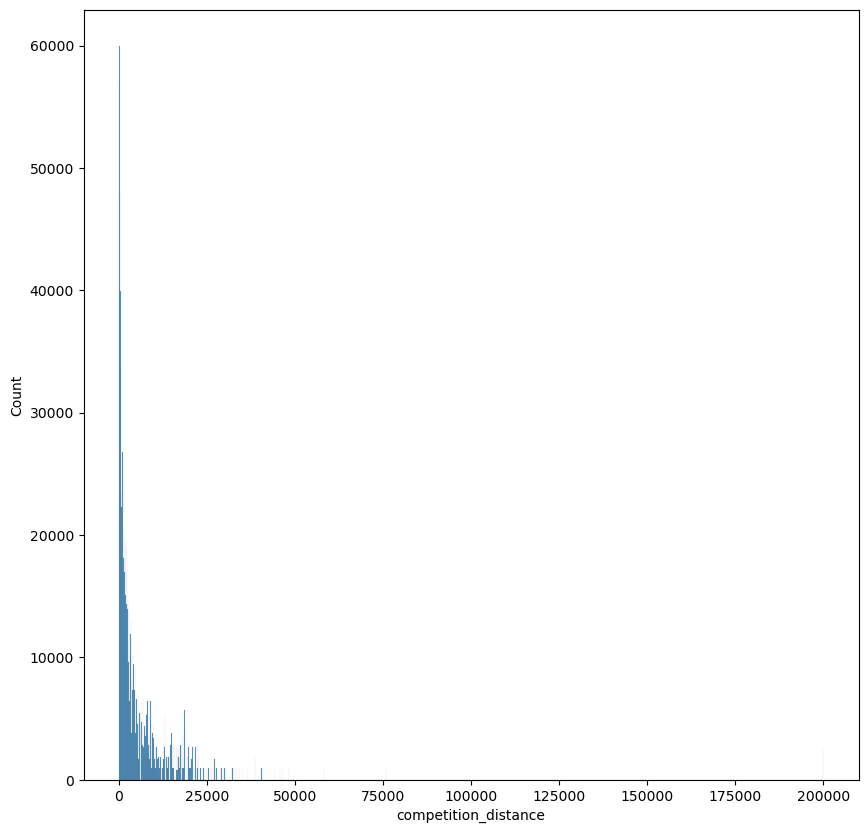

In [33]:
sns.histplot( df1['competition_distance'], kde=False )

<Axes: xlabel='assortment', ylabel='sales'>

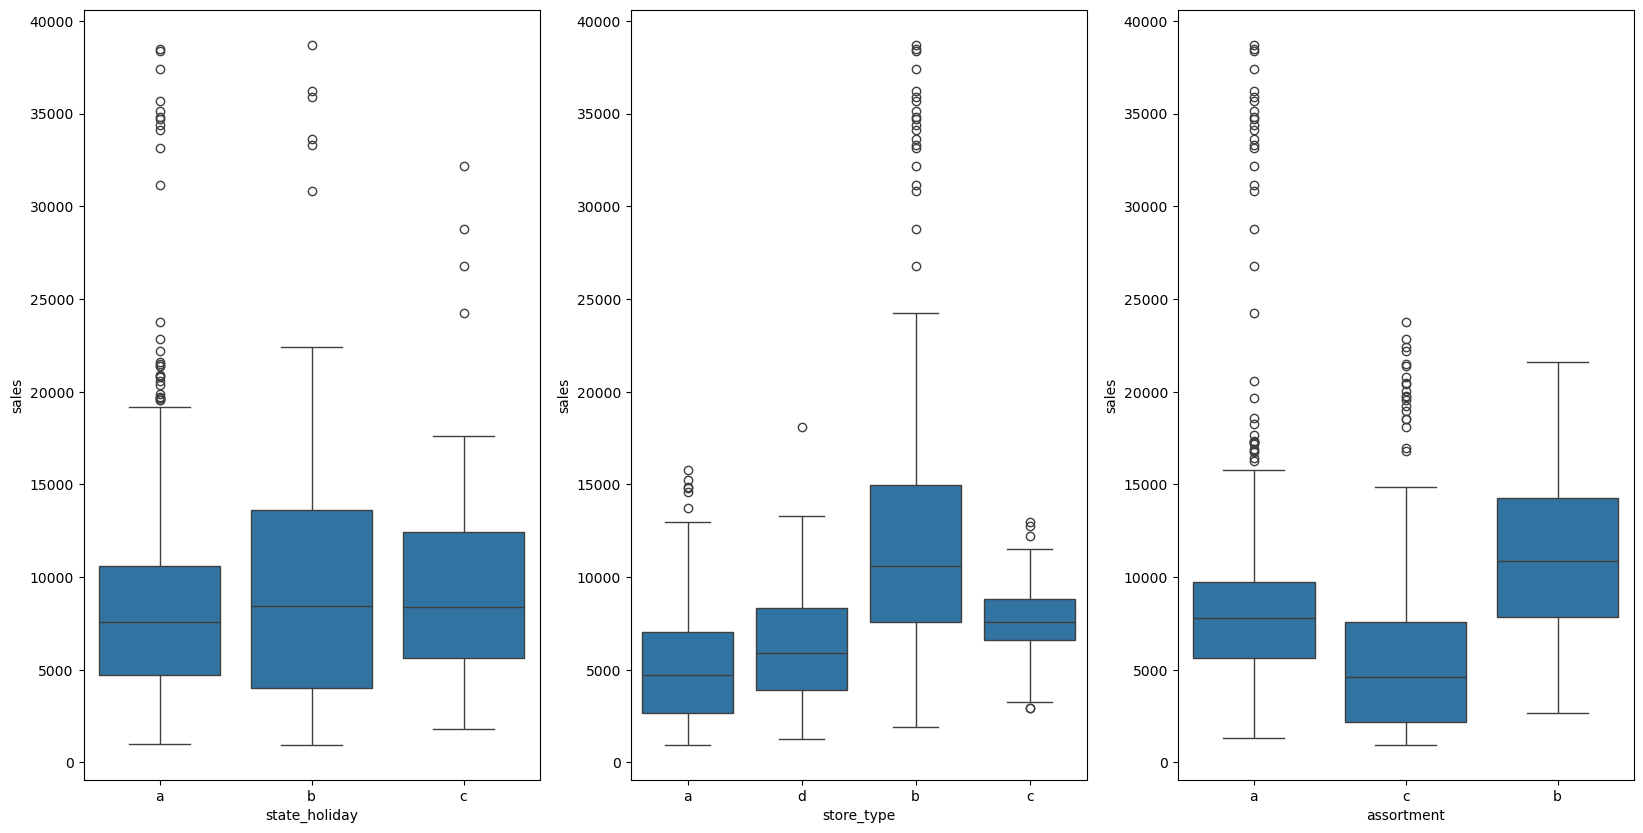

In [34]:
plt.figure(figsize=(20, 10))

aux = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]
plt.subplot( 1, 3, 1 )
sns.boxplot( x='state_holiday', y='sales', data=aux )
plt.subplot( 1, 3, 2 )
sns.boxplot( x='store_type', y='sales', data=aux )
plt.subplot( 1, 3, 3 )
sns.boxplot( x='assortment', y='sales', data=aux )


## HIPOTESIS MINDMAP

- Fenômeno: Qual modelo estou modelando?
- Agentes: Quem são os agentes que atuam sobre o fenômeno de interesse?
- Atributos dos Agentes: Qual a descrição dos agentes?
- Lista de Hipóteses: Hipóteses para validar com dados

In [36]:
Image('D:\data-science\projects-datascience\ds-producao\img\MIND_MAP.PNG')

FileNotFoundError: No such file or directory: 'D:\data-science\projects-datascience\ds-producao\img\MIND_MAP.PNG'

FileNotFoundError: No such file or directory: 'D:\data-science\projects-datascience\ds-producao\img\MIND_MAP.PNG'

<IPython.core.display.Image object>

## 2.1 Hypotheses creation

### 2.1.1 Store Hipotheses

1 - Stores with a higher number of employees should sell more.

2 - Stores with larger inventory capacity should sell more.

3 - Stores with larger size should sell more.

4 - Stores with a wider assortment should sell more.

5 - Stores with closer competitors should sell less.

6 - Stores with competitors that have been around longer should sell more.

### 2.1.2 Product Hipotheses

1 - Stores that invest more in marketing should sell more.

2 - Stores with greater product exposure should sell more.

3 - Stores with lower-priced products should sell more.

4 - Stores with more aggressive promotions (larger discounts) should sell more.

5 - Stores with promotions active for longer periods should sell more.

6 - Stores with more days of promotion should sell more.

7 - Stores with more consecutive promotions should sell more.

### 2.1.3 Time Hipotheses

1 - Stores open during the Christmas holiday should sell more.

2 - Stores should sell more over the years.

3 - Stores should sell more in the second half of the year.

4 - Stores should sell more after the 10th of each month.

5 - Stores should sell less on weekends.

6 - Stores should sell less during school holidays.

### 2.1.4 Final Hipotheses

1 - Stores with a wider assortment should sell more.

2 - Stores with closer competitors should sell less.

3 - Stores with competitors that have been around longer should sell more.

4 - Stores with promotions active for longer periods should sell more.

5 - Stores with more days of promotion should sell more.

6 - Stores with more consecutive promotions should sell more.

7 - Stores open during the Christmas holiday should sell more.

8 - Stores should sell more over the years.

9 - Stores should sell more in the second semester of the year.

10 - Stores should sell more after the 10th of each month.

11 - Stores should sell less on weekends.

12 - Stores should sell less during school holidays.

## 2.2 Feature Engineering

In [43]:
df2 = df1.copy()

In [44]:
#year
df2['year'] = df2['date'].dt.year
#day
df2['day'] = df2['date'].dt.day
#month
df2['month'] = df2['date'].dt.month
# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week
# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')
# competition since
df2['competition_since'] = df2.apply( lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'],day=1 ), axis=1 )
df2['competition_time_month'] = ( ( df2['date'] - df2['competition_since'] )/30).apply( lambda x: x.days ).astype( int )
#promo since
df2['promo_since'] = df2['promo2_since_year'].astype( str ) + '-' + df2['promo2_since_week'].astype( str )
df2['promo_since'] = df2['promo_since'].apply( lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w' ) - datetime.timedelta( days=7 ) )
df2['promo_time_week'] = ( ( df2['date'] - df2['promo_since'] )/7 ).apply(lambda x: x.days ).astype( int )
#assortiment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended' )
#state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day' )


In [45]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


## 3.0 Variable Filtering

In [47]:
df3 = df2.copy()
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,is_promo,year,day,month,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,...,0,2015,31,7,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,...,1,2015,31,7,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,...,1,2015,31,7,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,...,0,2015,31,7,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,...,0,2015,31,7,31,2015-30,2015-04-01,4,2015-07-27,0


### 3.1 Filtering rows

In [49]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,is_promo,year,day,month,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,...,0,2015,31,7,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,...,1,2015,31,7,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,...,1,2015,31,7,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,...,0,2015,31,7,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,...,0,2015,31,7,31,2015-30,2015-04-01,4,2015-07-27,0


### 3.2 Selecting Columns

In [51]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df3 = df3.drop(cols_drop, axis=1)

## 4.0 Exploratory data analysis

### Goals: 

1 - Gain business experience.

2 - Validate business hypotheses ( Insights )

3 - Variables importants for the model.


In [53]:
df4 = df3.copy()

### 4.1 Análise Univariada

#### 4.1.1 Variável resposta

<Axes: xlabel='sales', ylabel='Density'>

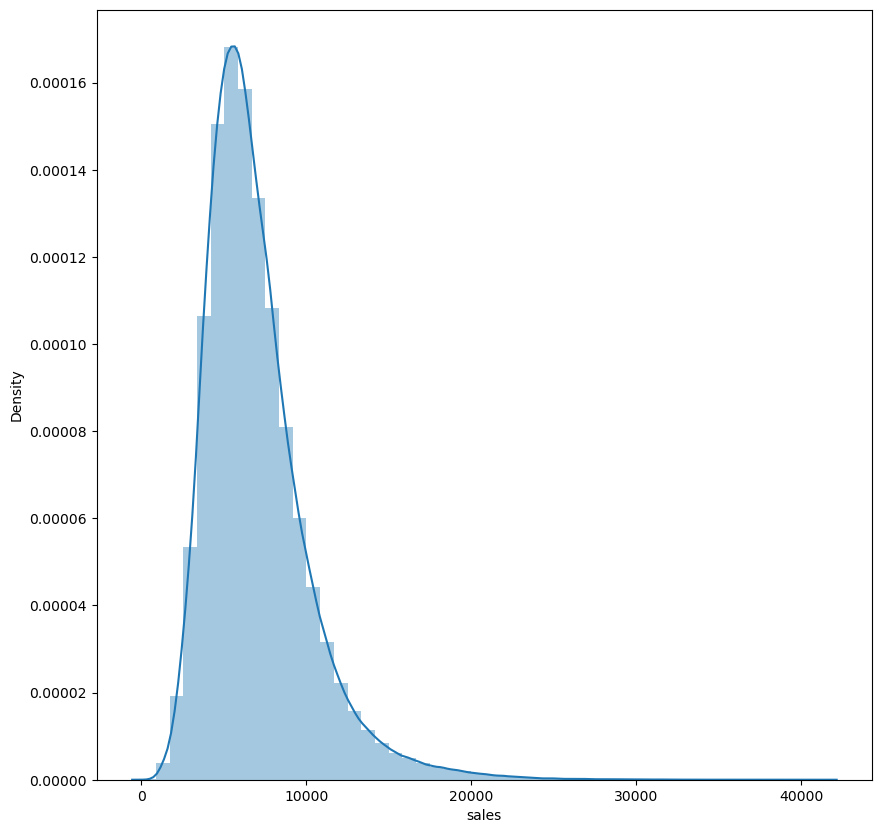

In [56]:
sns.distplot(df4['sales'])

#### 4.1.2 Variável numérica

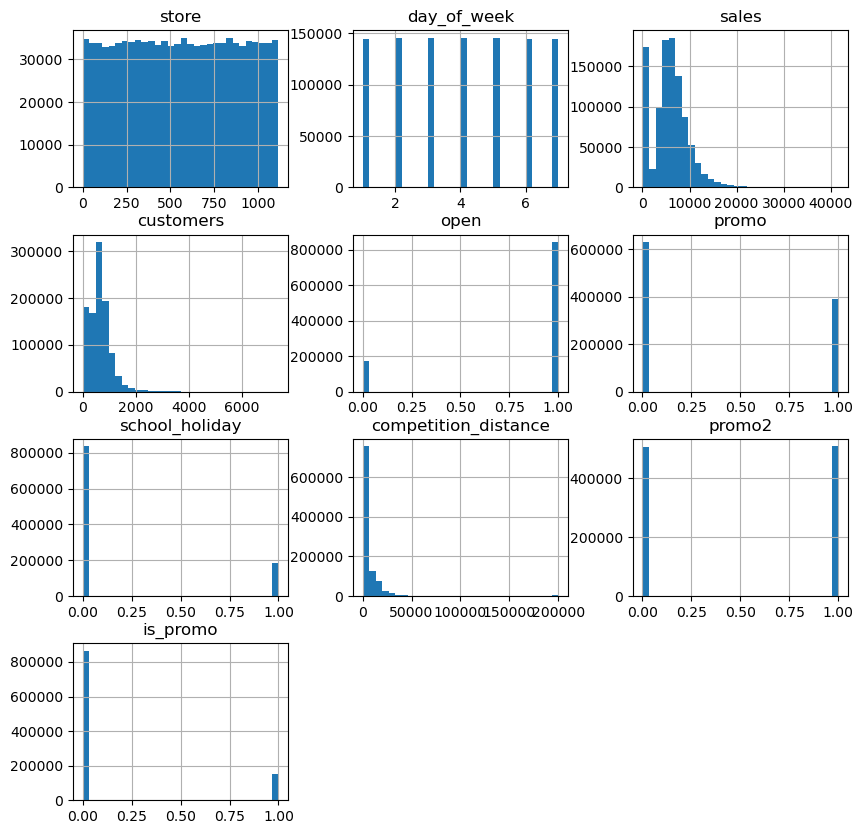

In [58]:
num_attributes.hist(bins=30);
mpl.rcParams['figure.figsize'] = [20, 17]

plt.show()

#### 4.1.3 Variável categórica

In [60]:
df4['state_holiday'].drop_duplicates()
df4['store_type'].drop_duplicates()

0     c
1     a
12    d
84    b
Name: store_type, dtype: object

<Axes: xlabel='sales', ylabel='Density'>

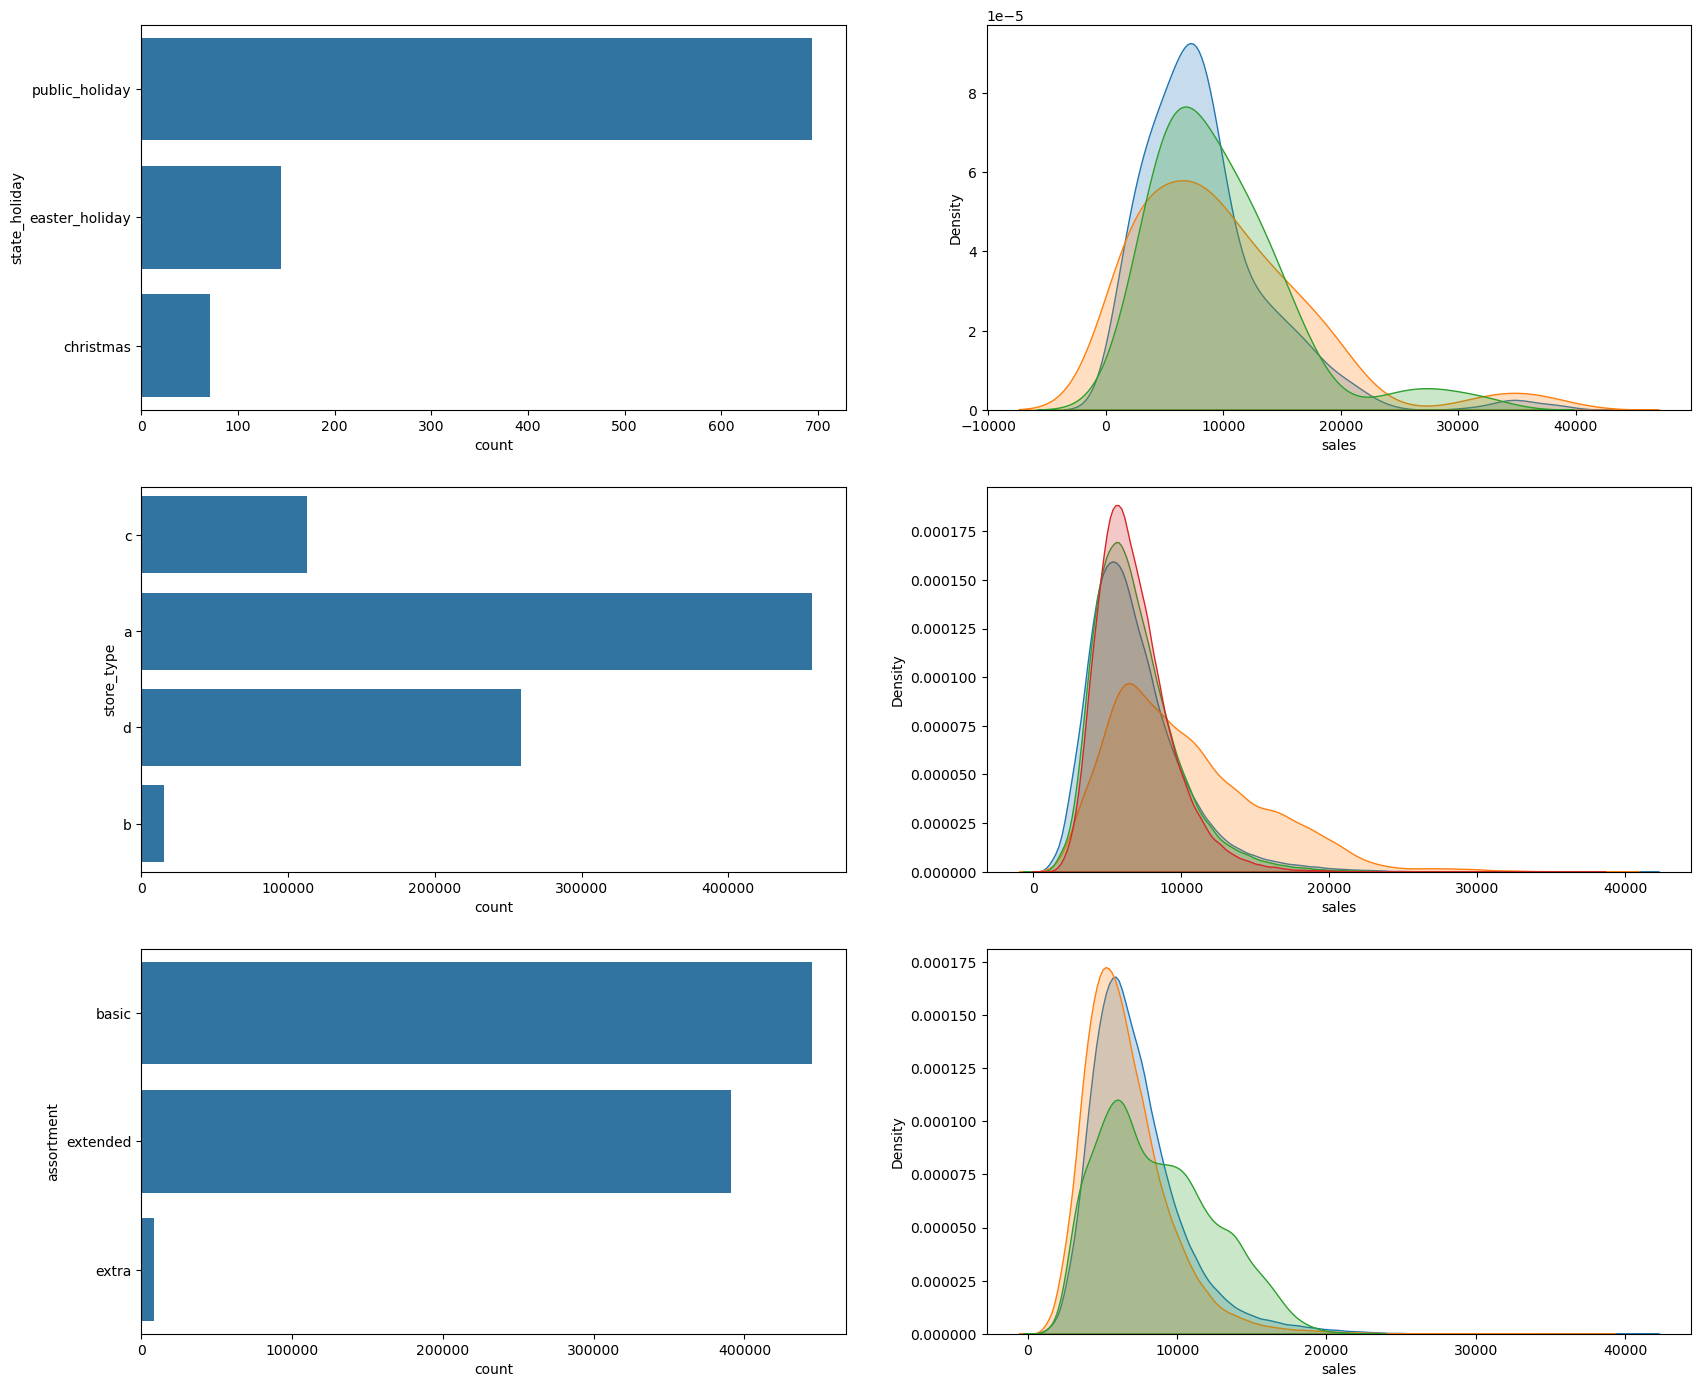

In [61]:
warnings.simplefilter(action="ignore", category=FutureWarning)
# state holiday
plt.subplot(3, 2, 1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'])

plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label= 'public_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label= 'easter_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label= 'christmas', shade=True)

#store type

plt.subplot(3 , 2, 3)
sns.countplot(df4['store_type'])


plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label= 'a', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label= 'b', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label= 'c', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label= 'd', shade=True)

#assortiment


plt.subplot(3 , 2, 5)
sns.countplot(df4['assortment'])

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label= 'extended', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label= 'basic', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label= 'extra', shade=True)



### 4.2 Analise Bivariada

#### H1. Lojas com maior sortimentos deveriam vender mais
***FALSA*** Lojas com MAIOR sortimento vendem MENOS.

<Axes: xlabel='year_week'>

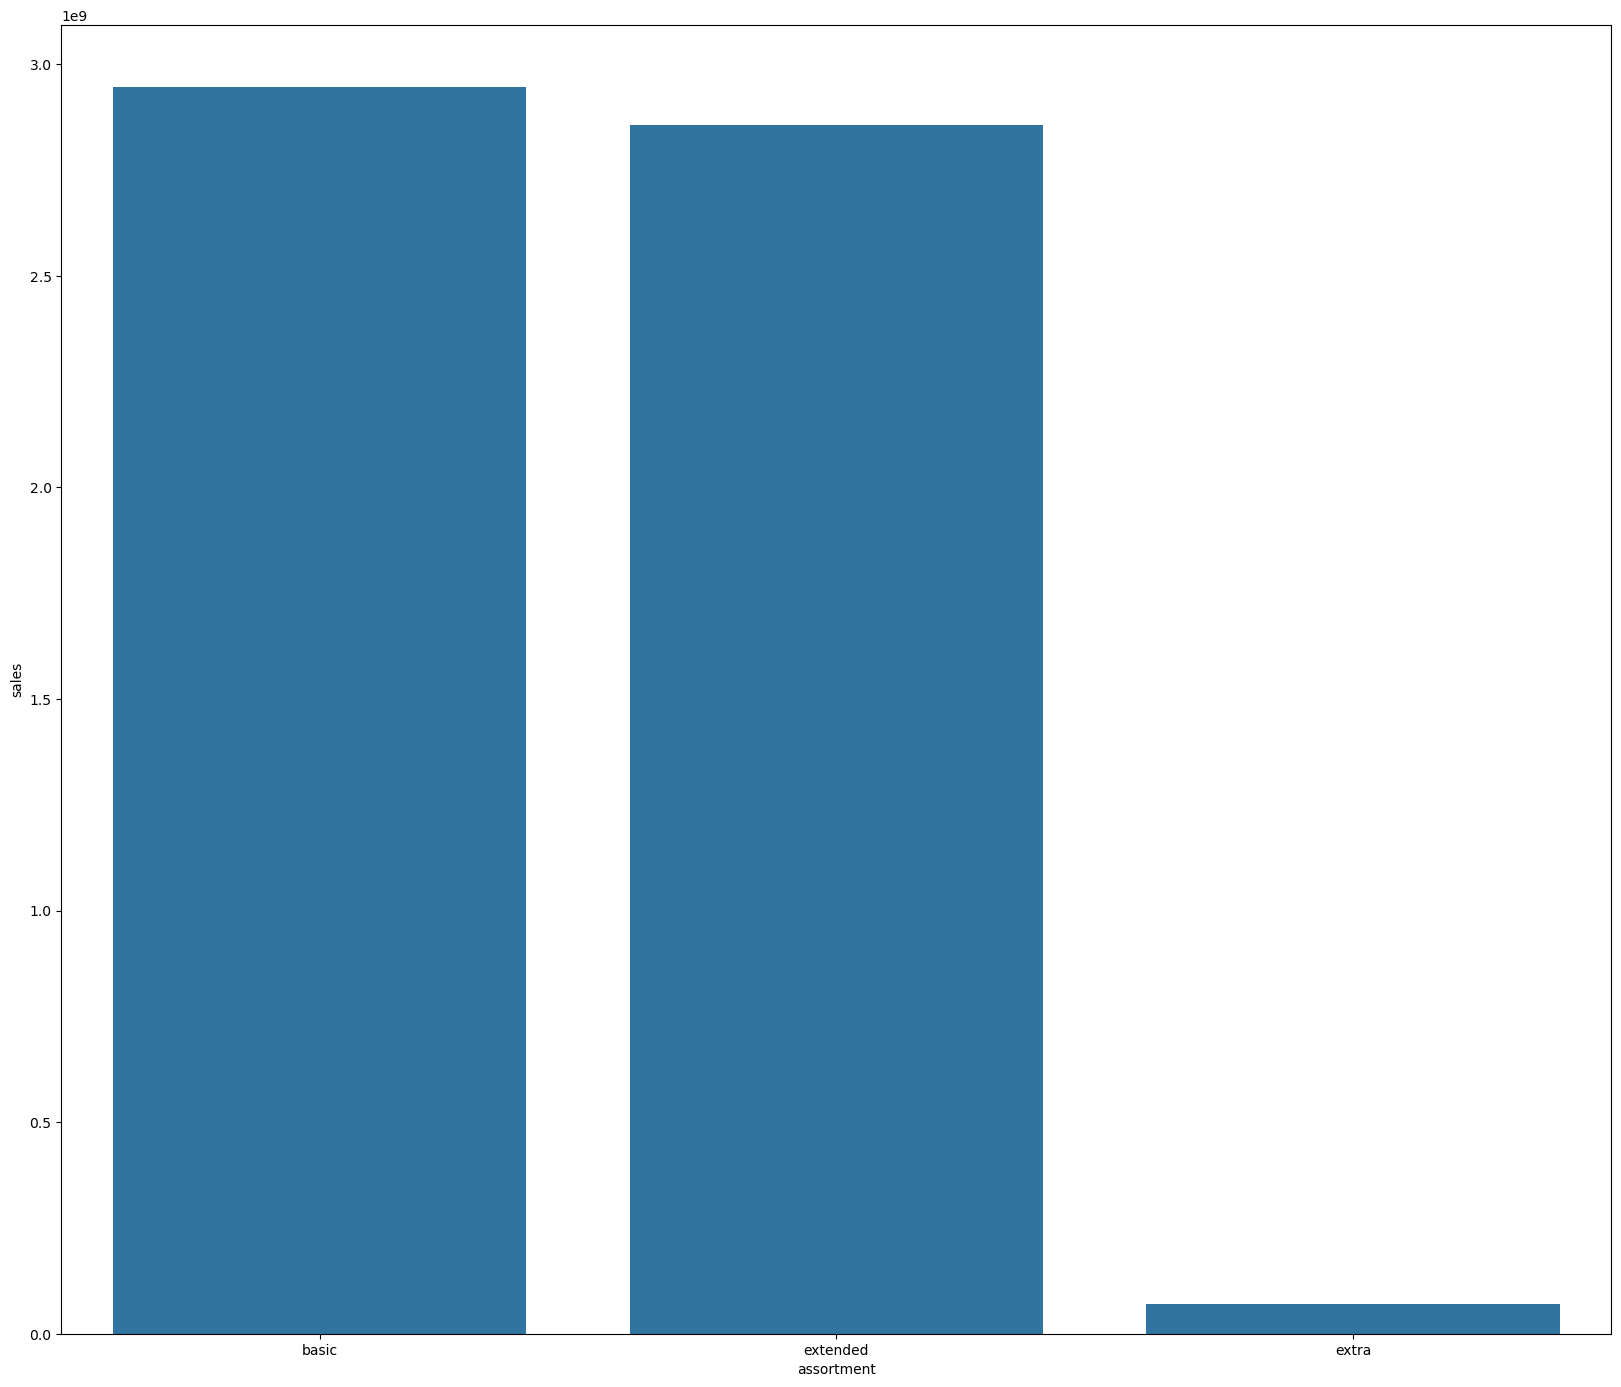

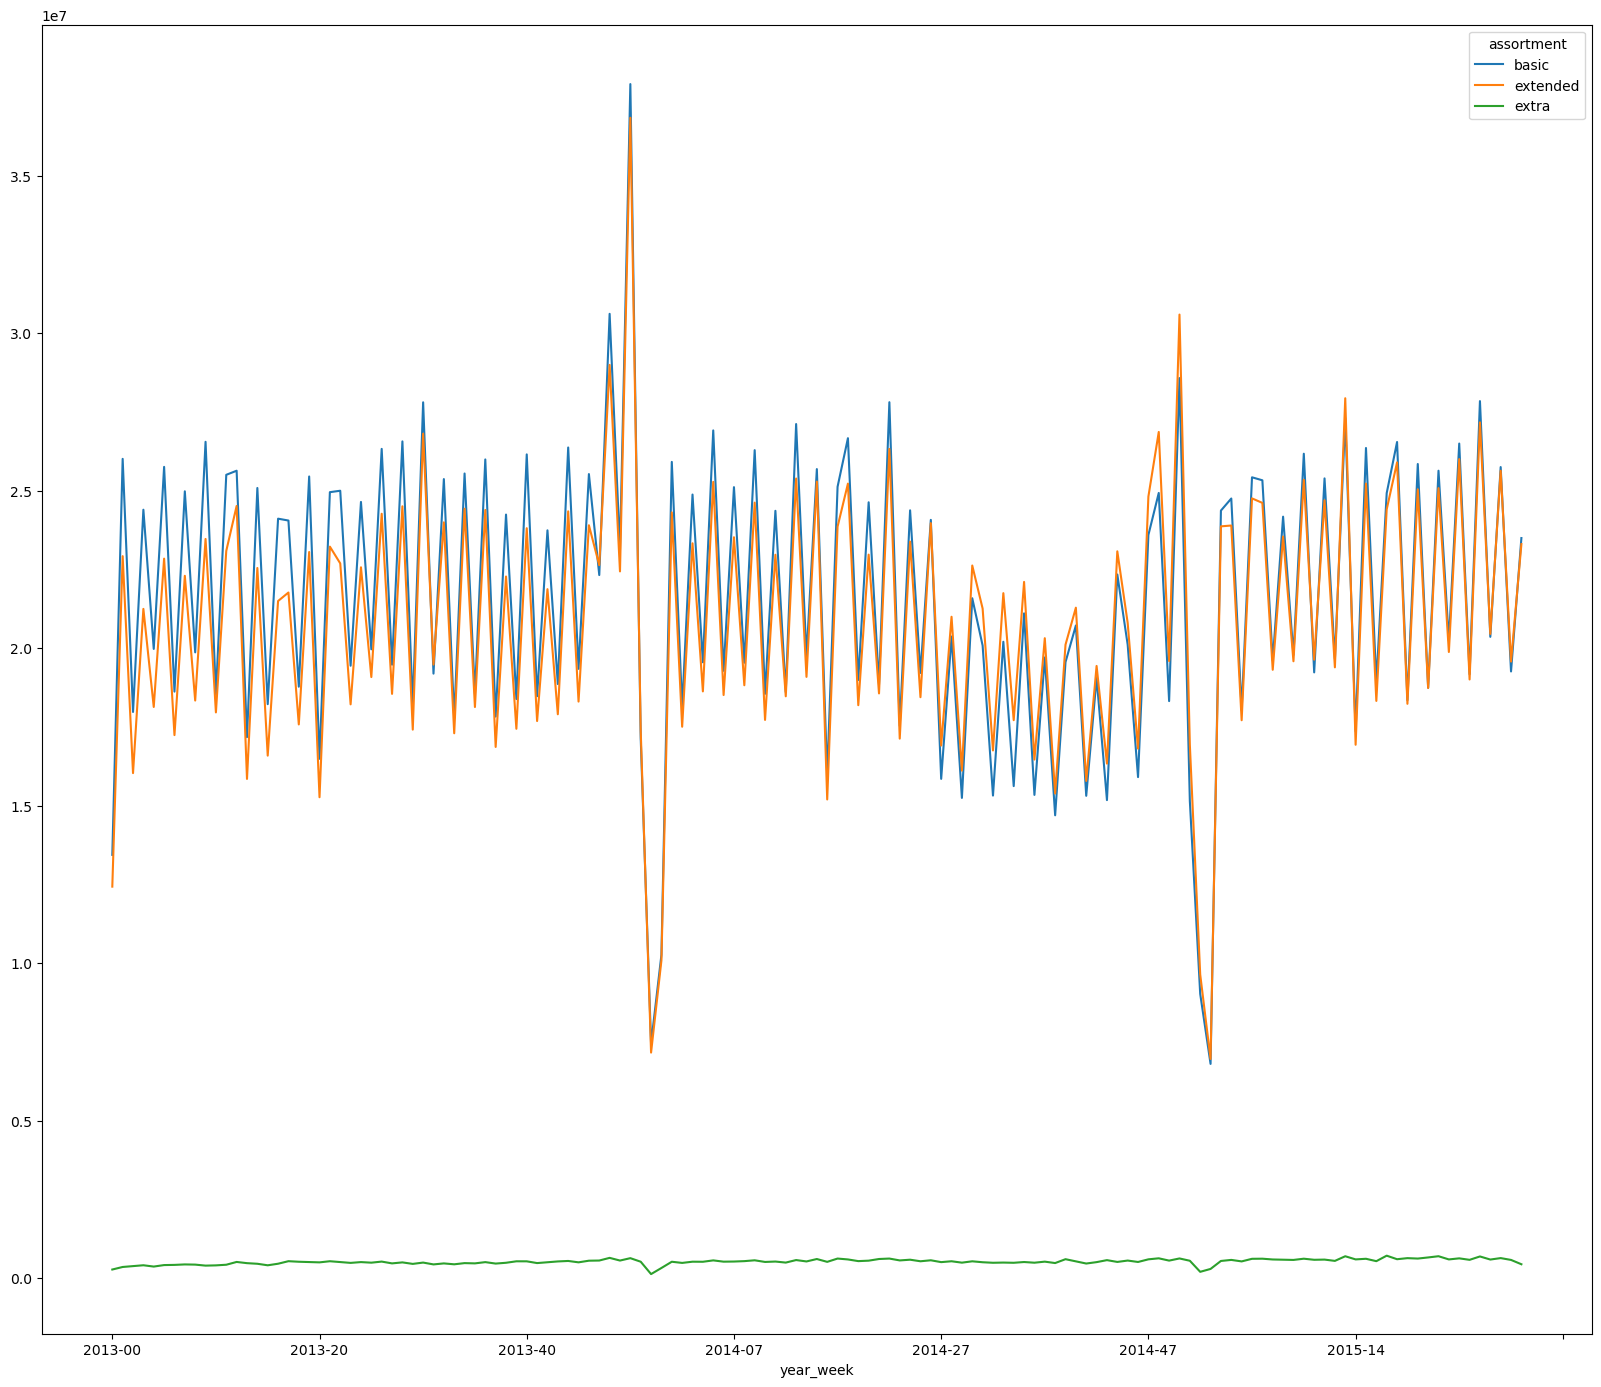

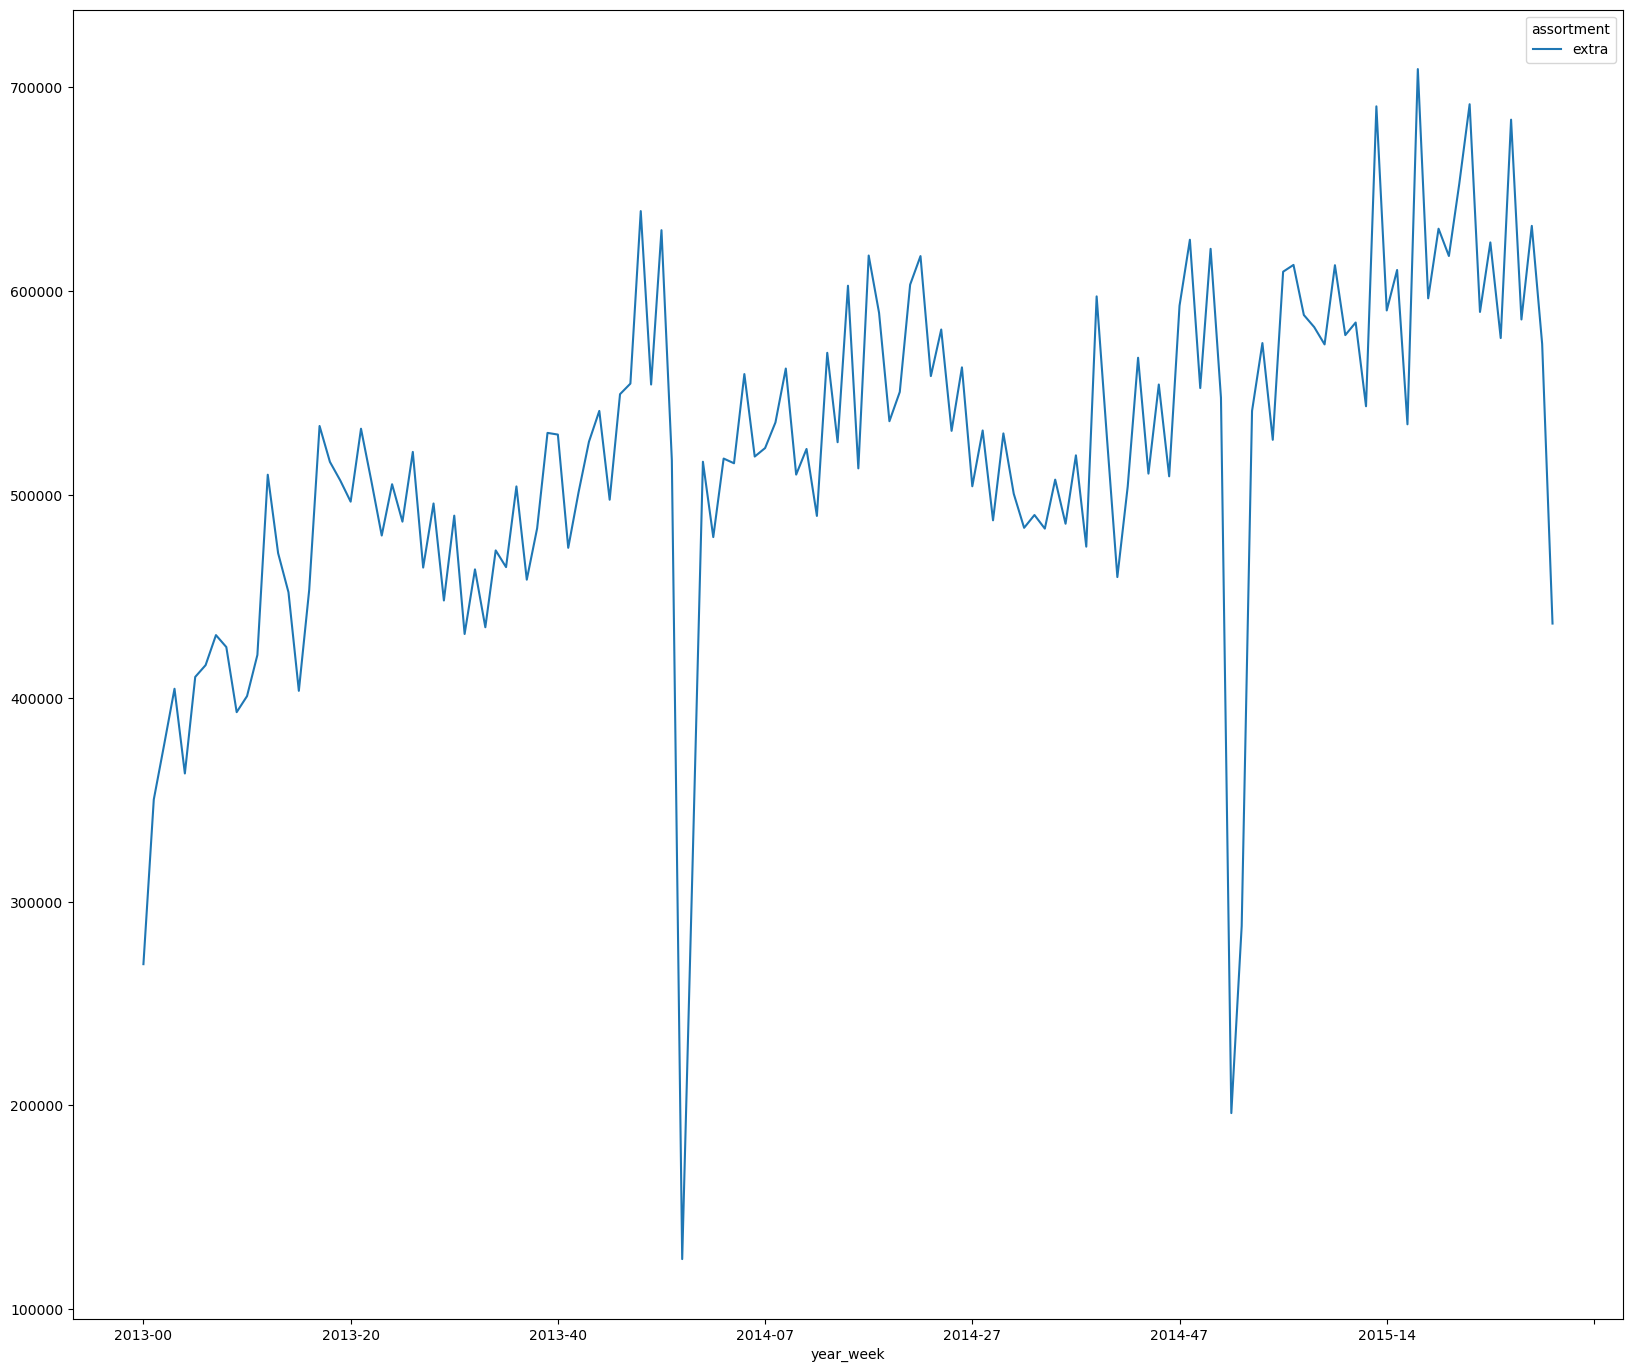

In [64]:
aux1 = df4[['assortment','sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data=aux1)

aux2 = df4[['year_week','assortment','sales']].groupby(['year_week','assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot()

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot()

#### H2. Lojas com competidores mais próximos deveriam vender menos.
***FALSA*** Lojas com competidores mais próximos vendem MAIS.

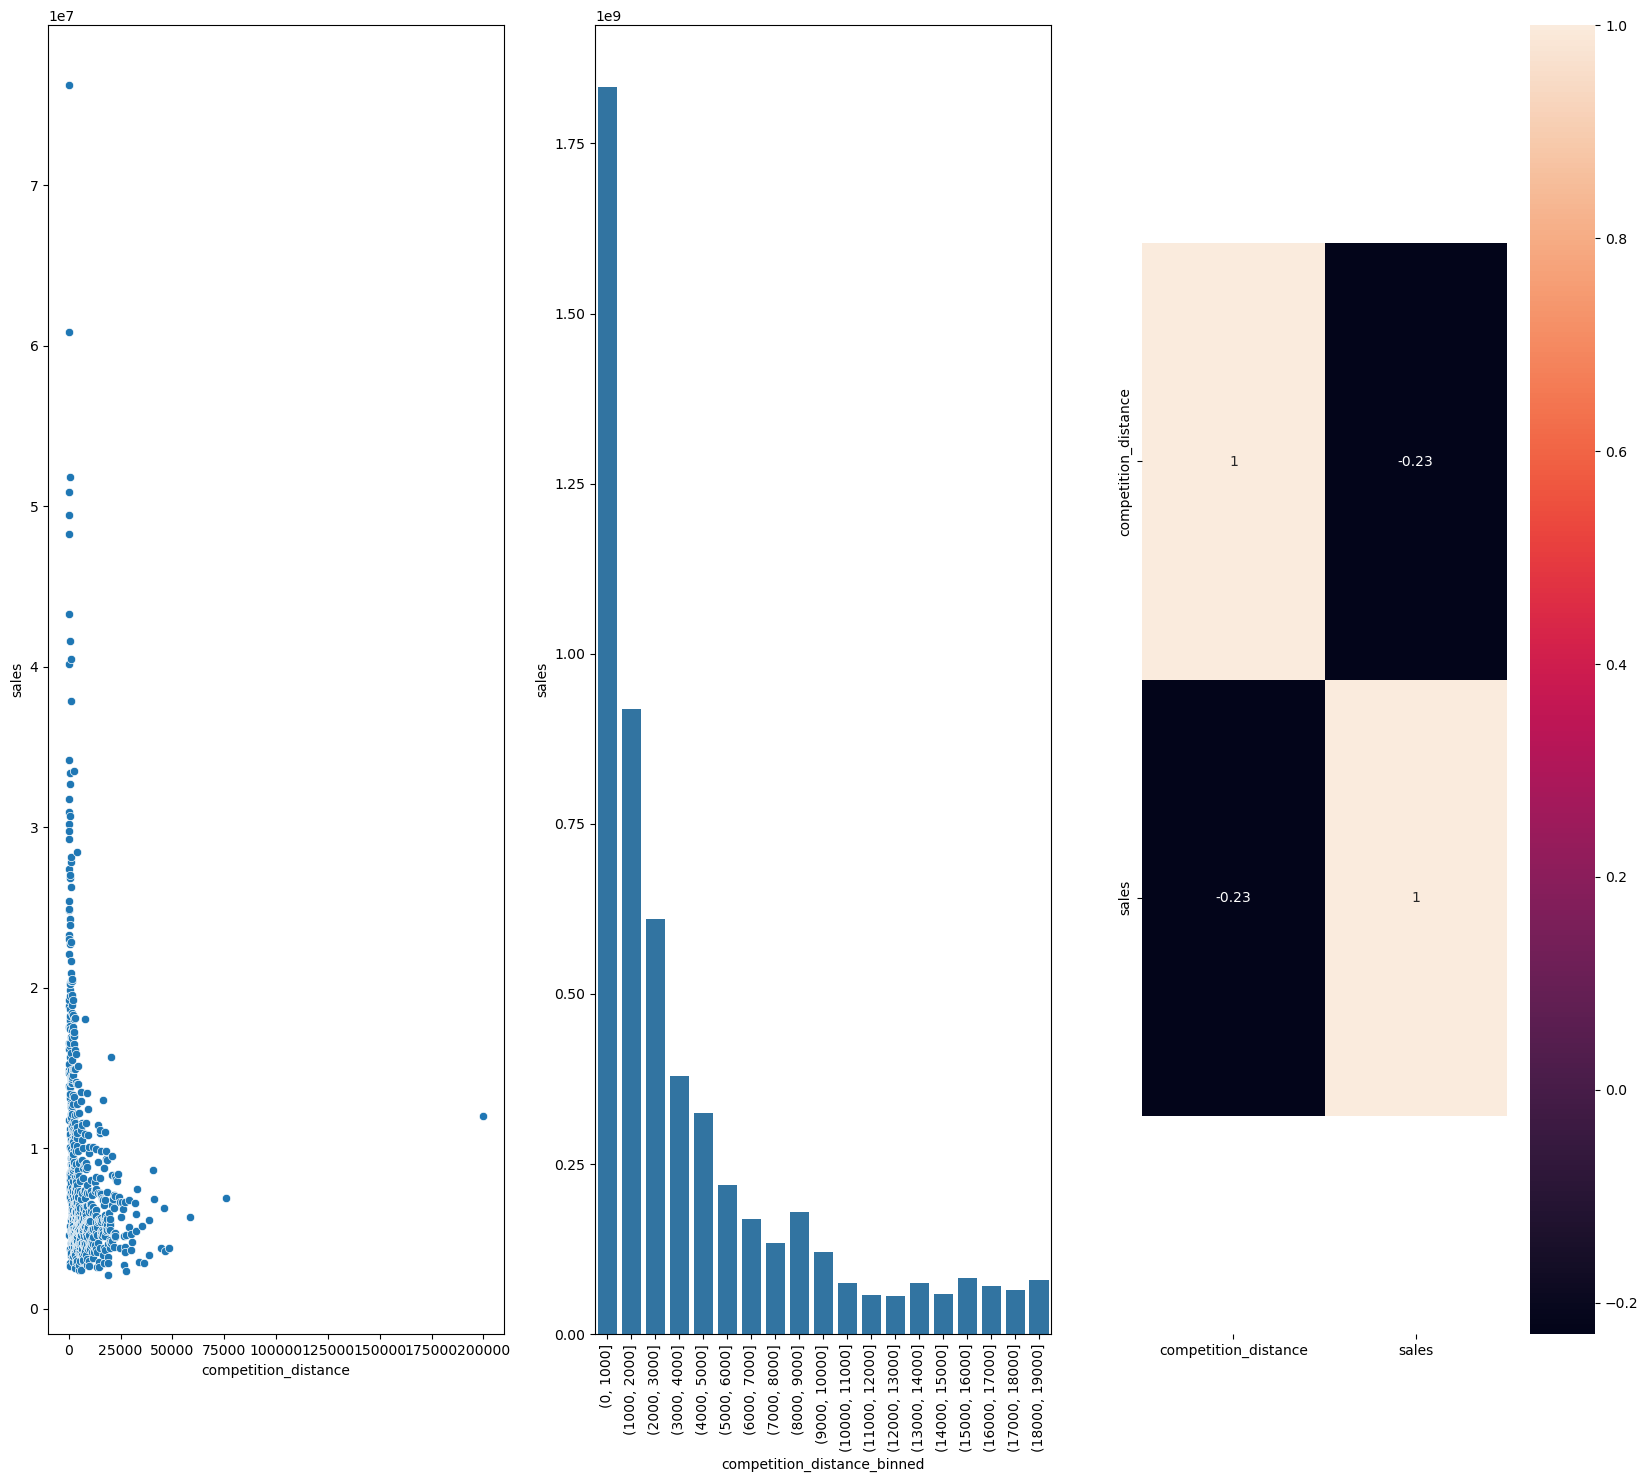

In [66]:
aux1 = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1, 3, 1)
sns.scatterplot(x='competition_distance', y='sales', data=aux1);

plt.subplot(1, 3, 2)
bins = list(np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data=aux2);
plt.xticks(rotation=90)

# Cálculo de força da correlação, apenas com colunas numéricas
plt.subplot(1, 3, 3)
corr_matrix = aux1[['competition_distance', 'sales']].corr(method='pearson')
x = sns.heatmap(corr_matrix, annot=True);
bottom, top = x.get_ylim()
x.set_ylim( bottom+0.5, top-0.5);

#### H3. Lojas com competidores à mais tempo deveriam vender mais.
***FALSA*** Lojas com competidores a mais tempo vendem MENOS

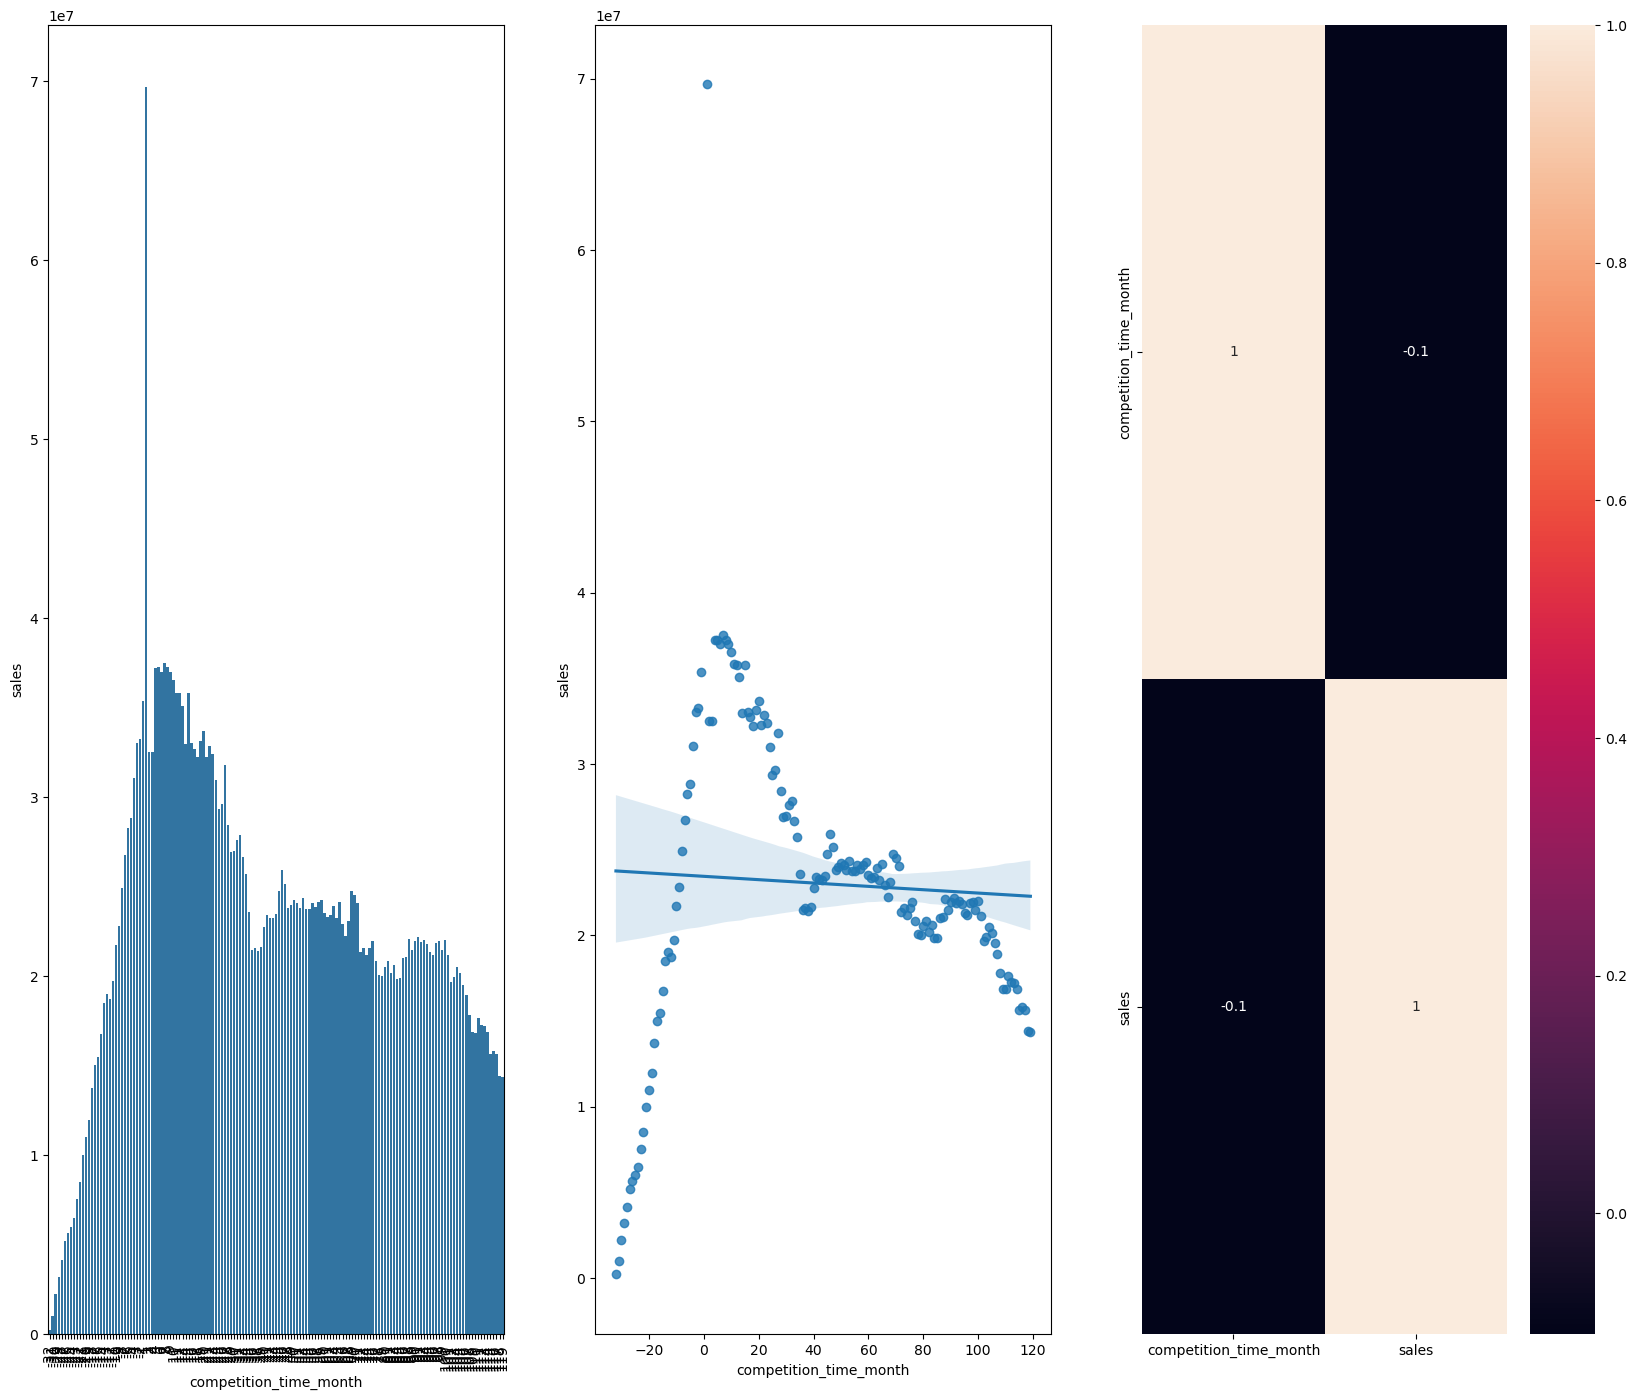

In [68]:
plt.subplot(1,3,1)
aux1 = df4[['competition_time_month','sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0 )]
sns.barplot(x='competition_time_month', y='sales', data=aux2);
plt.xticks(rotation=90);

plt.subplot(1,3,2)
sns.regplot(x='competition_time_month', y='sales', data=aux2);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);


#### H4. Lojas com promocoes ativas por mais tempo deveriam mais.
***FALSA*** Lojas com promoções ativas por mais tempo vendem MENOS

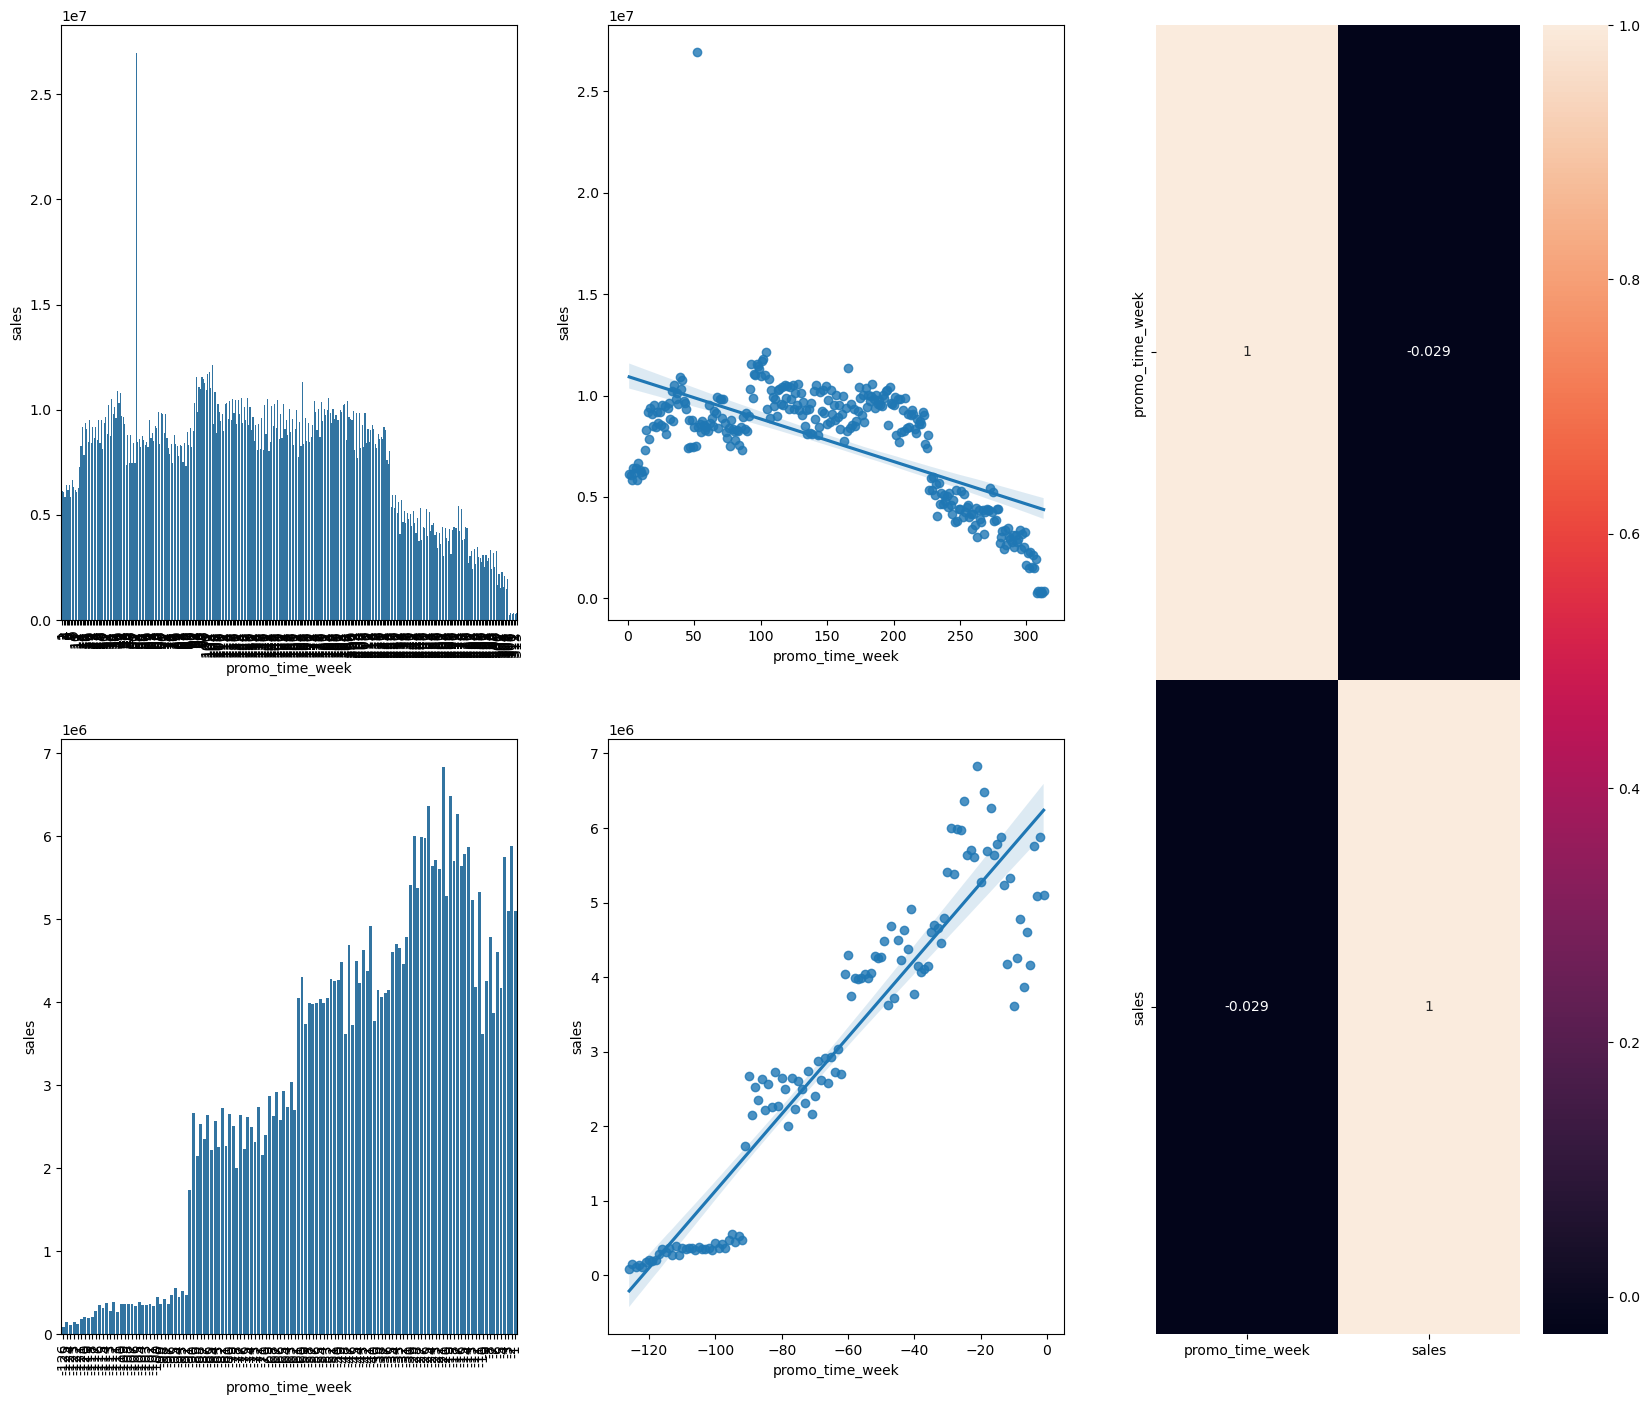

In [70]:
aux1 = df4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()


grid = GridSpec(2,3)

plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week'] > 0] #promo extendido
sns.barplot (x='promo_time_week', y='sales',data=aux2);
plt.xticks(rotation=90);

plt.subplot(grid[0,1])
sns.regplot (x='promo_time_week', y='sales',data=aux2);

plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week'] < 0] #promo regular
sns.barplot (x='promo_time_week', y='sales',data=aux3);
plt.xticks(rotation=90);

plt.subplot(grid[1,1])
sns.regplot (x='promo_time_week', y='sales',data=aux3);

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method='pearson'), annot=True);

#### H7. Lojas com mais promoções consecutivas deveriam vender mais.
FALSA - Lojas com mais promoções consecutivas vendem menos

In [72]:
df4[['promo', 'promo2', 'sales']].groupby(['promo','promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


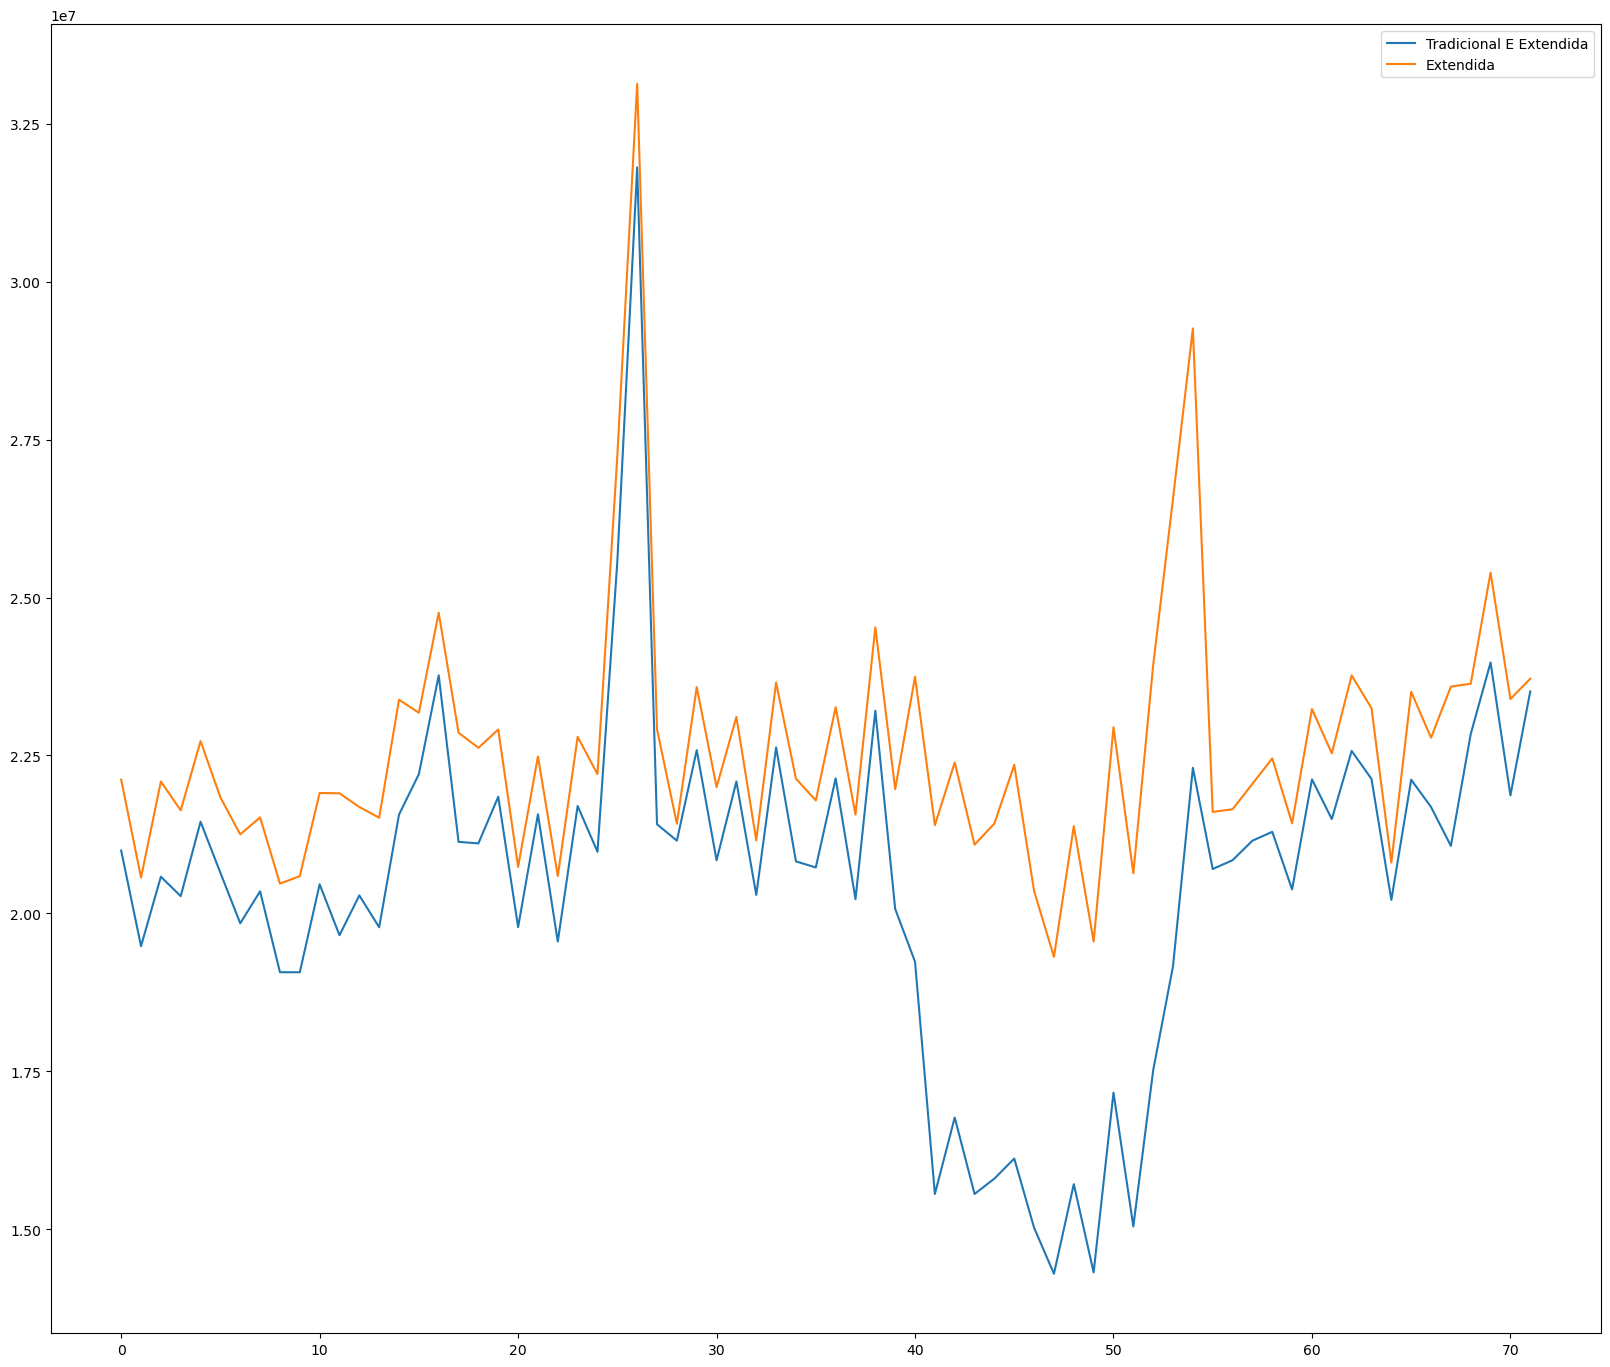

In [73]:
aux1 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 1 )][['year_week','sales']].groupby( 'year_week' ).sum().reset_index()
ax = aux1.plot()
aux2 = df4[( df4['promo'] == 1 ) & ( df4['promo2'] == 0 )][['year_week', 'sales']].groupby( 'year_week' ).sum().reset_index()
aux2.plot (ax=ax)
ax.legend(labels=['Tradicional E Extendida', 'Extendida'])


#### H8. Lojas abertas durante o feriado de Natal deveriam vender mais.
FALSA - Lojas abertas durante Natal vendem menos

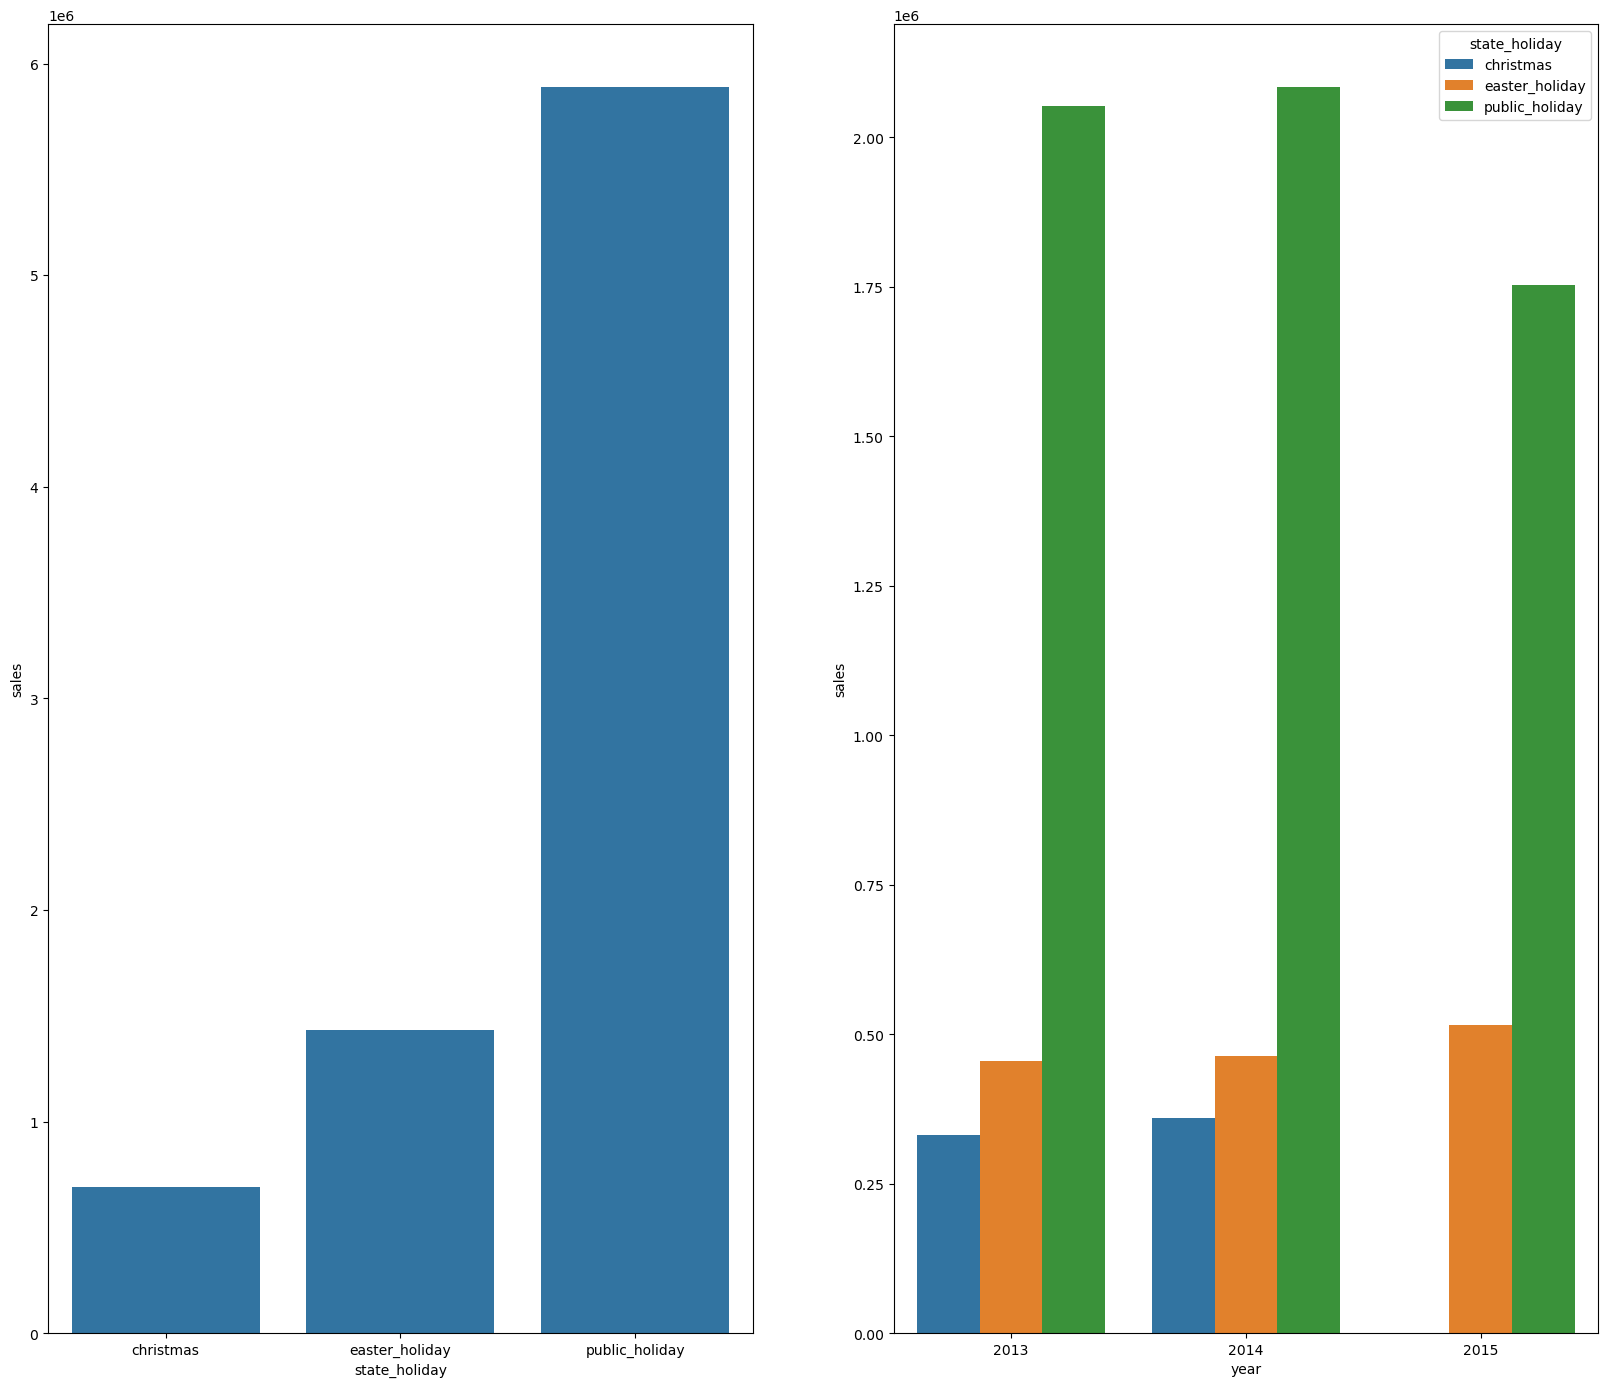

In [75]:
aux = df4[df4['state_holiday'] != 'regular_day']
plt.subplot( 1, 2, 1 )
aux1 = aux[['state_holiday', 'sales']].groupby( 'state_holiday' ).sum().reset_index()

sns.barplot( x='state_holiday', y='sales', data=aux1 );
plt.subplot( 1, 2, 2 )
aux2 = aux[['year', 'state_holiday', 'sales']].groupby( ['year','state_holiday']).sum().reset_index()
sns.barplot( x='year', y='sales', hue='state_holiday', data=aux2 );




#### H9. Lojas deveriam vender mais ao longo dos anos.
FALSA - Lojas vendem menos ao longo dos anos

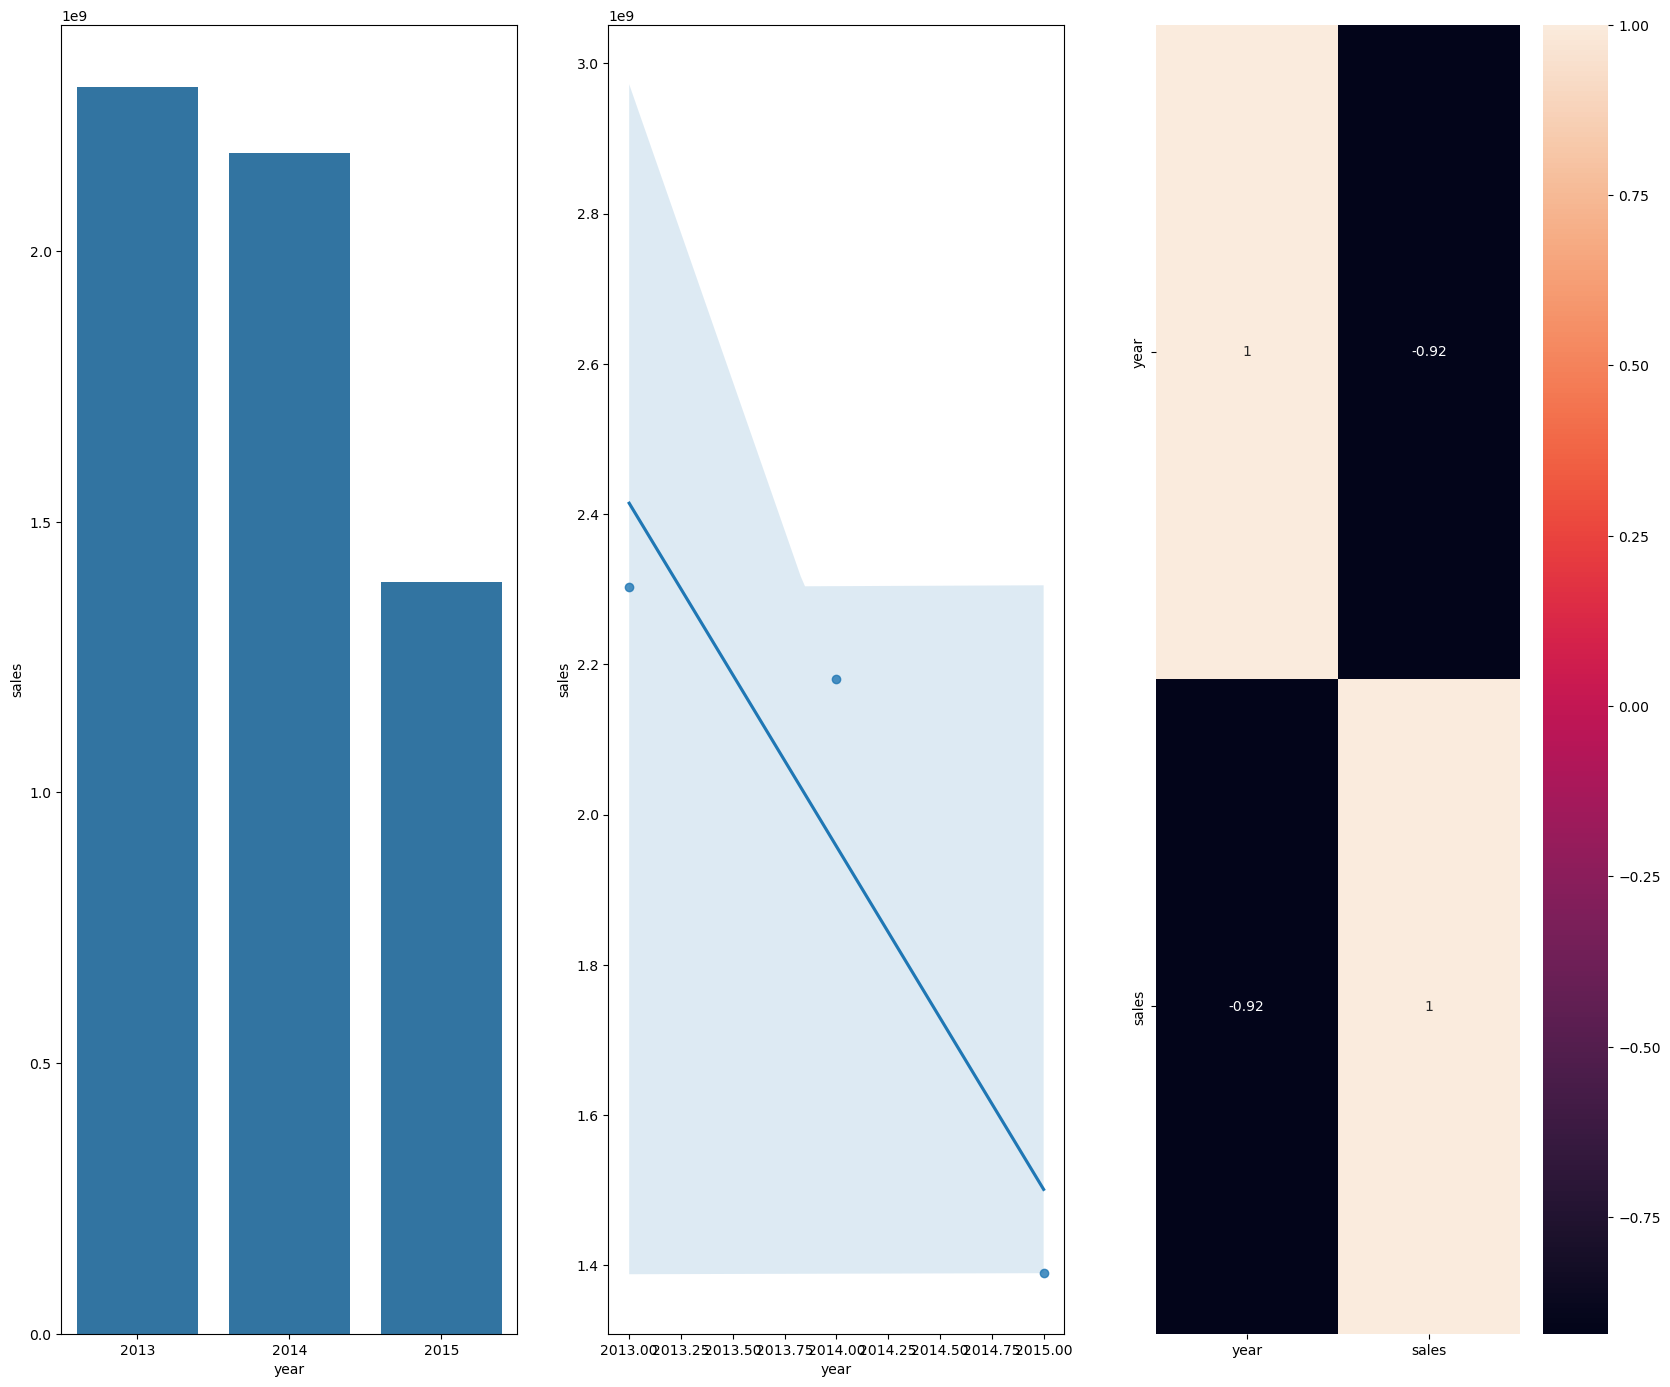

In [77]:
aux1 = df4[['year', 'sales']].groupby( 'year' ).sum().reset_index()
plt.subplot( 1, 3, 1 )
sns.barplot( x='year', y='sales', data=aux1 );
plt.subplot( 1, 3, 2 )
sns.regplot( x='year', y='sales', data=aux1 );
plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );


#### H10. Lojas deveriam vender mais no segundo semestre do ano.
FALSA - Lojas vendem menos no segundo semestre

<Axes: >

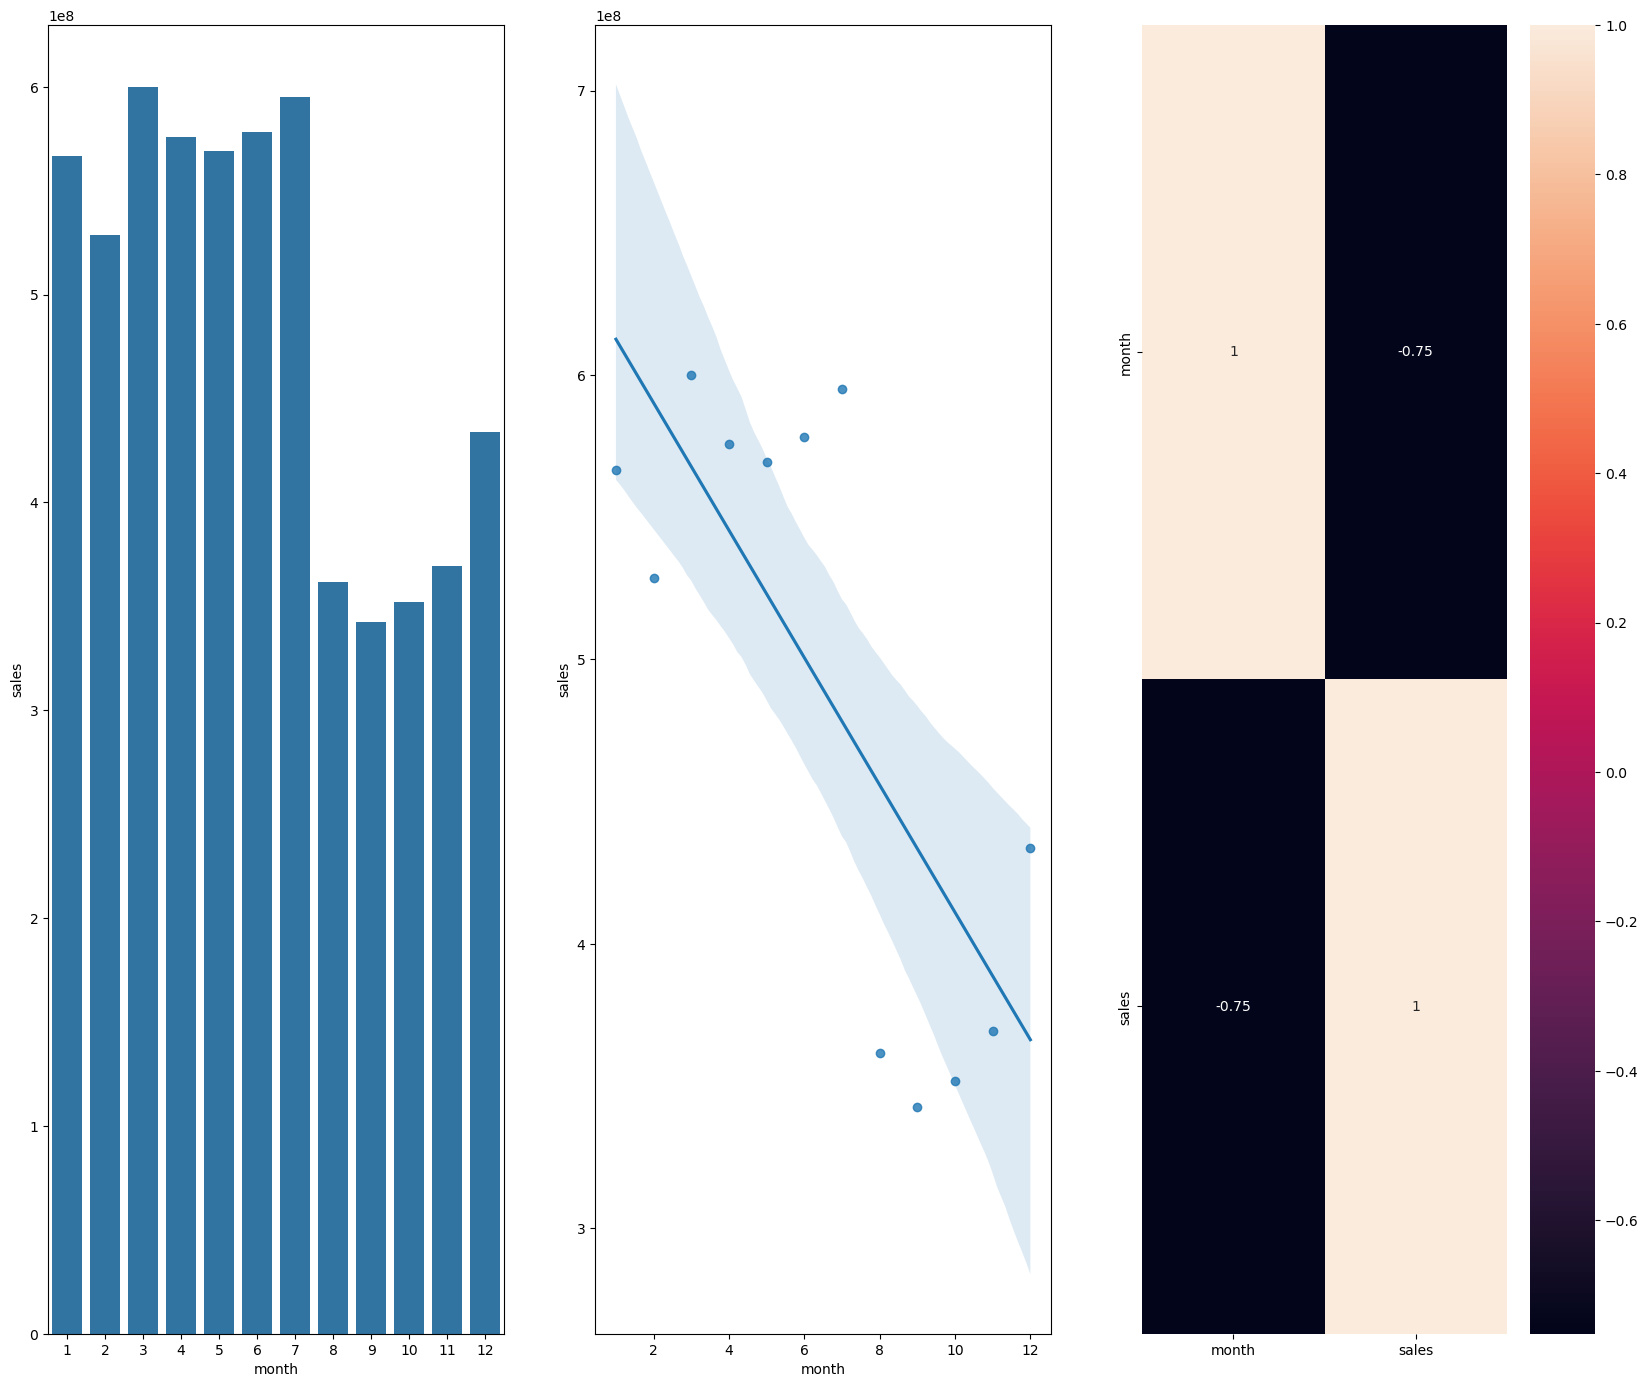

In [79]:
aux1 = df4[['month', 'sales']].groupby( 'month' ).sum().reset_index()
plt.subplot( 1, 3, 1 )
sns.barplot( x='month', y='sales', data=aux1 );
plt.subplot( 1, 3, 2 )
sns.regplot( x='month', y='sales', data=aux1 );
plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True )

#### H11. Lojas deveriam vender mais depois do dia 10 de cada mes
VERDADEIRA - Lojas vendem mais pós dia 10

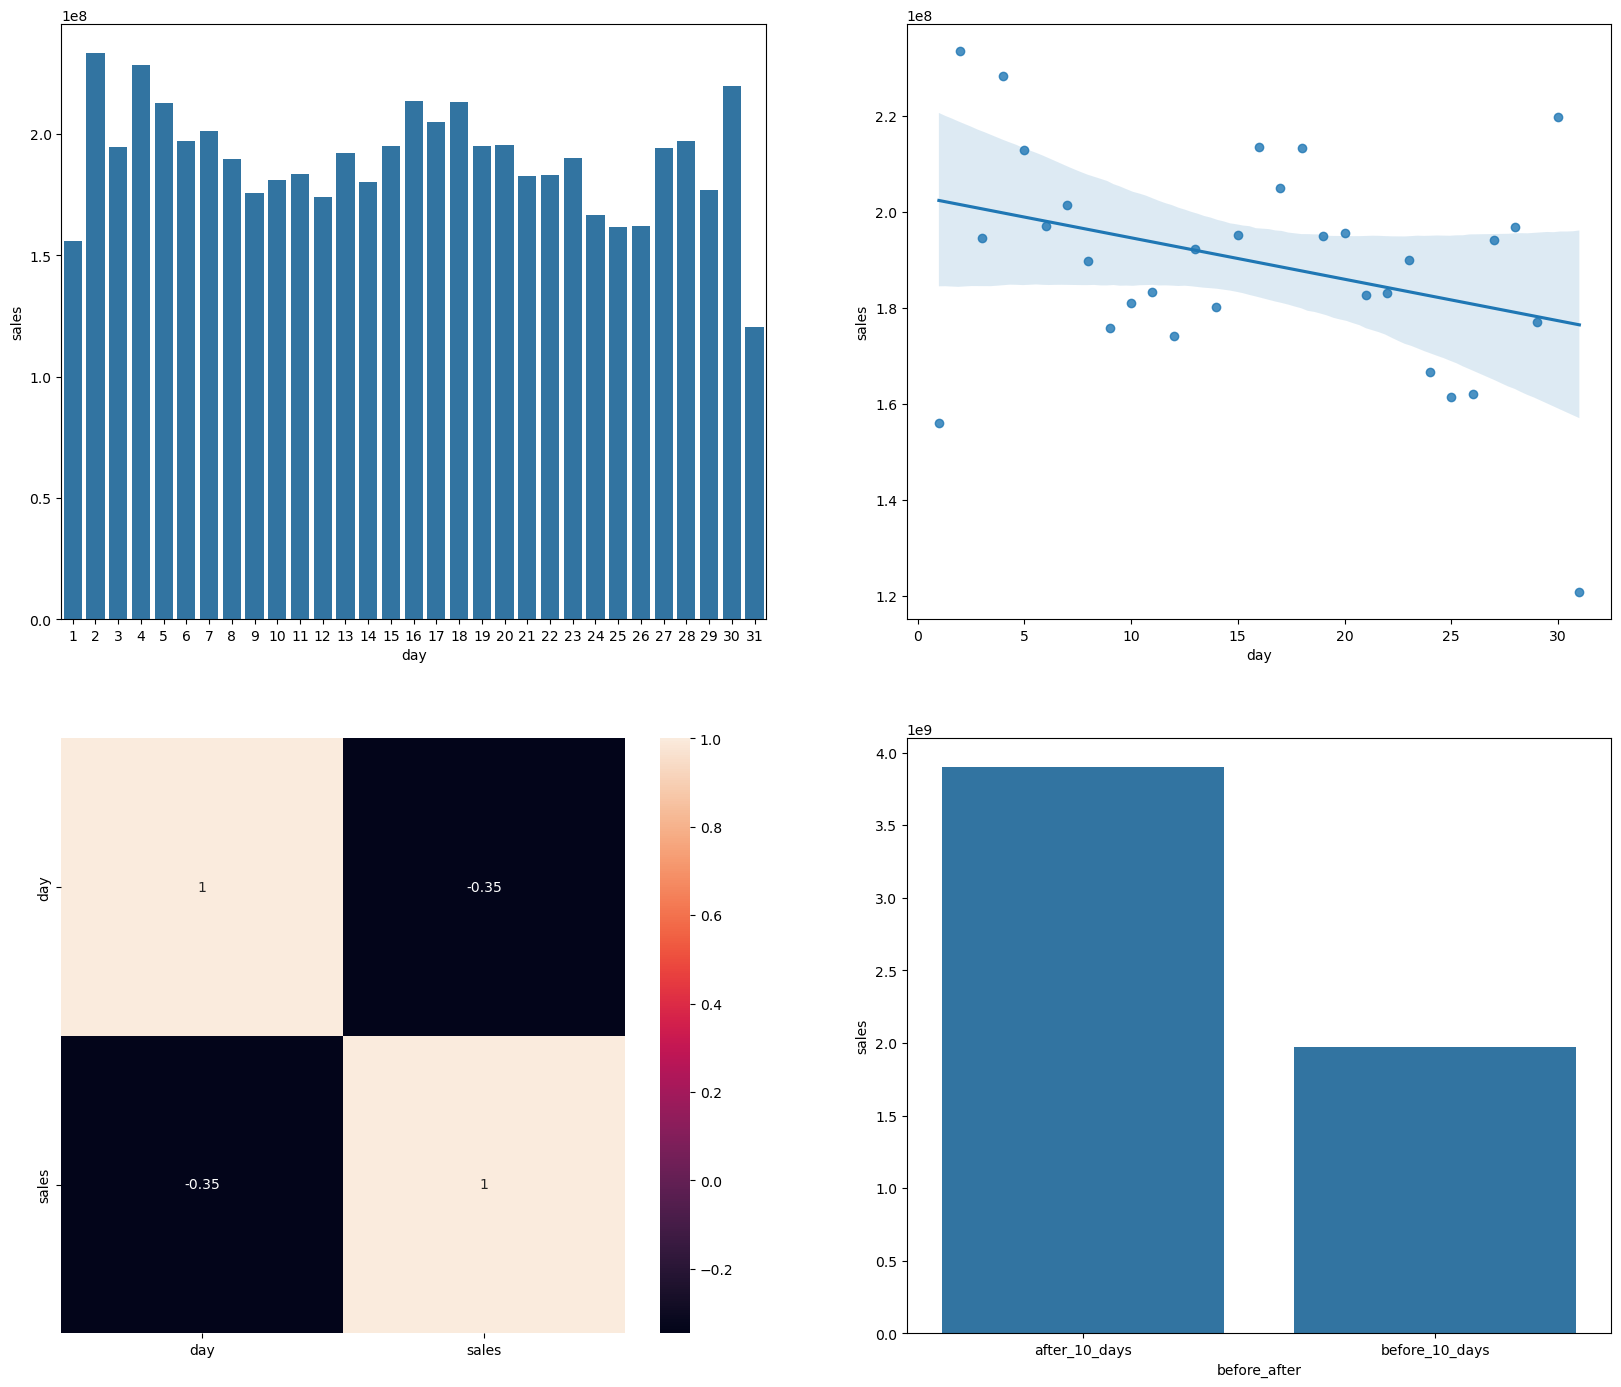

In [81]:
aux1 = df4[['day', 'sales']].groupby( 'day' ).sum().reset_index()
plt.subplot( 2, 2, 1 )
sns.barplot( x='day', y='sales', data=aux1 );
plt.subplot( 2, 2, 2 )
sns.regplot( x='day', y='sales', data=aux1 );
plt.subplot( 2, 2, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );

aux1['before_after'] = aux1['day'].apply( lambda x: 'before_10_days' if x <= 10 else 'after_10_days' )
aux2 =aux1[['before_after', 'sales']].groupby( 'before_after' ).sum().reset_index()

plt.subplot( 2, 2, 4 )
sns.barplot( x='before_after', y='sales', data=aux2 );

#### H12. Lojas deveriam vender menos aos finais de semana.
VERDADEIRA - Lojas vendem menos no fim de semana.

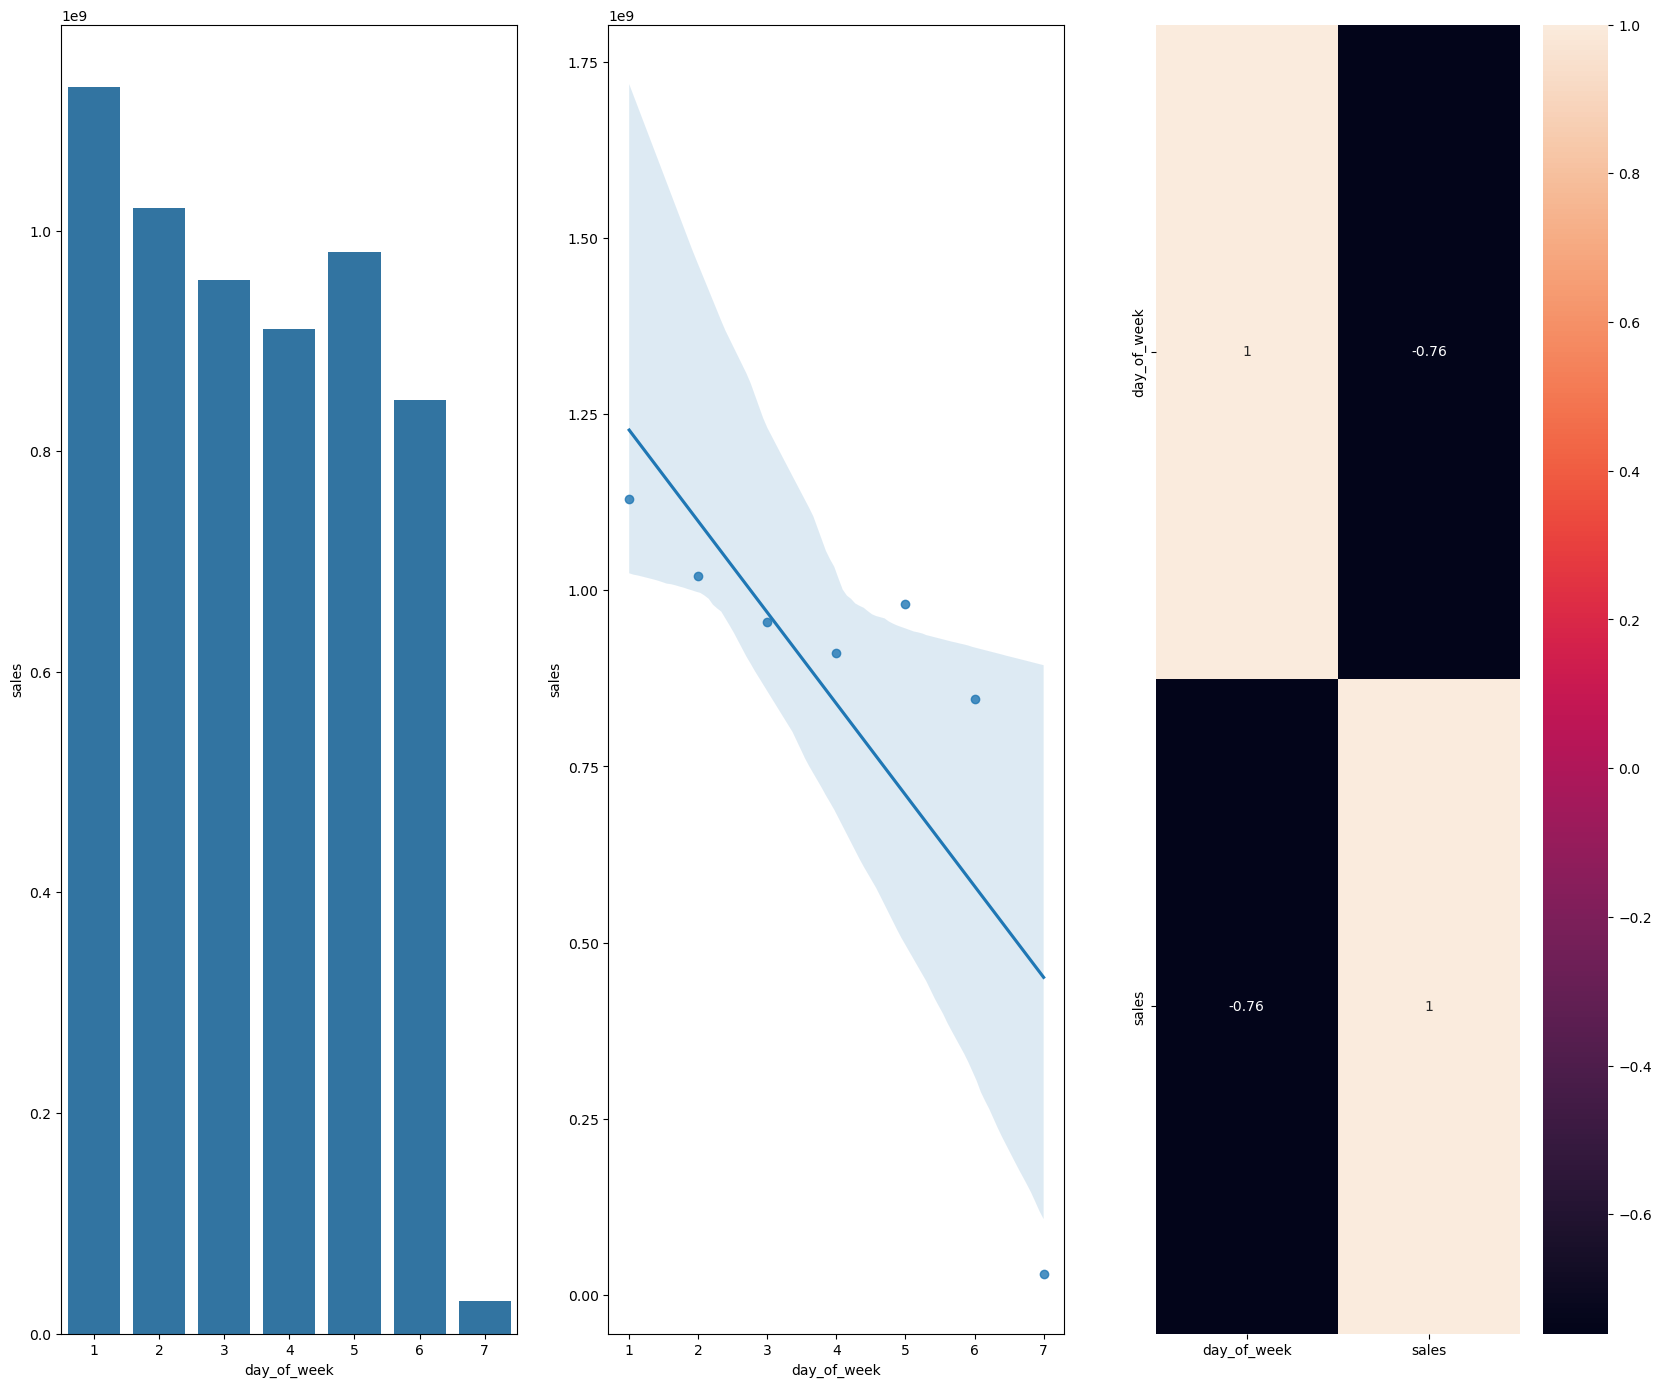

In [83]:
aux1 = df4[['day_of_week', 'sales']].groupby( 'day_of_week' ).sum().reset_index()
plt.subplot( 1, 3, 1 )
sns.barplot( x='day_of_week', y='sales', data=aux1 );
plt.subplot( 1, 3, 2 )
sns.regplot( x='day_of_week', y='sales', data=aux1 );
plt.subplot( 1, 3, 3 )
sns.heatmap( aux1.corr( method='pearson' ), annot=True );


#### H13. Lojas deveriam vender menos durante os feriados escolares.
VERDADEIRA - Lojas vendem menos durante os feriados escolares, exceto meses de julho e agosto

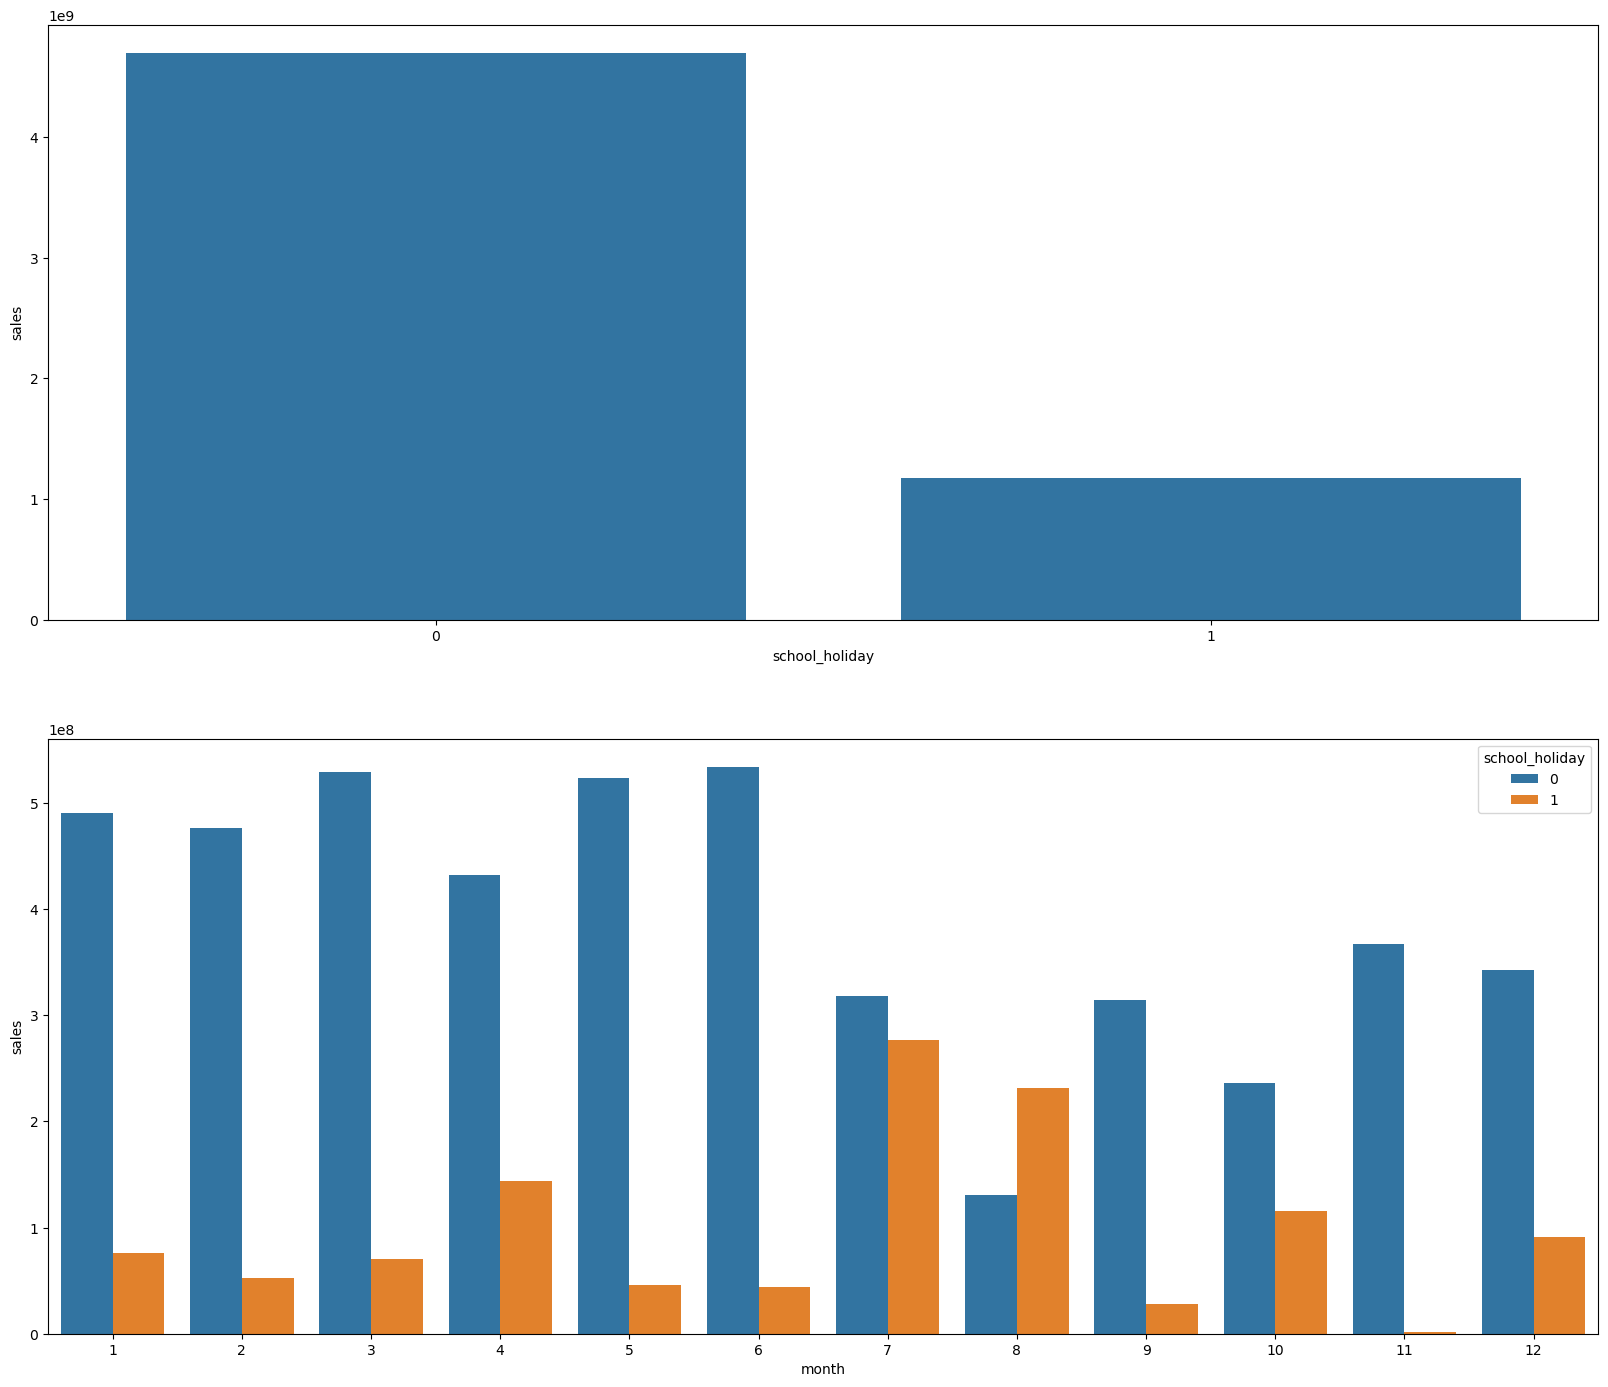

In [85]:
aux1 = df4[['school_holiday', 'sales']].groupby( 'school_holiday' ).sum().reset_index()
plt.subplot( 2, 1, 1 )
sns.barplot( x='school_holiday', y='sales', data=aux1 );
aux2 = df4[['month', 'school_holiday', 'sales']].groupby(['month','school_holiday'] ).sum().reset_index()
plt.subplot( 2, 1, 2 )
sns.barplot( x='month', y='sales', hue='school_holiday', data=aux2 );



#### Resumo das hipoteses

In [87]:
from tabulate import tabulate

In [88]:
tab =[['Hipoteses', 'Conclusao', 'Relevancia'],
['H1', 'Falsa', 'Baixa'],
['H2', 'Falsa', 'Media'],
['H3', 'Falsa', 'Media'],
['H4', 'Falsa', 'Baixa'],
['H5', '-', '-'],
['H7', 'Falsa', 'Baixa'],
['H8', 'Falsa', 'Media'],
['H9', 'Falsa', 'Alta'],
['H10', 'Falsa', 'Alta'],
['H11', 'Verdadeira', 'Alta'],
['H12', 'Verdadeira', 'Alta'],
['H13', 'Verdadeira', 'Baixa'],
]
print( tabulate( tab, headers='firstrow' ) )


Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H7           Falsa        Baixa
H8           Falsa        Media
H9           Falsa        Alta
H10          Falsa        Alta
H11          Verdadeira   Alta
H12          Verdadeira   Alta
H13          Verdadeira   Baixa


#### 4.3 Analise Multivariada

##### 4.3.1 Numerical Attributes

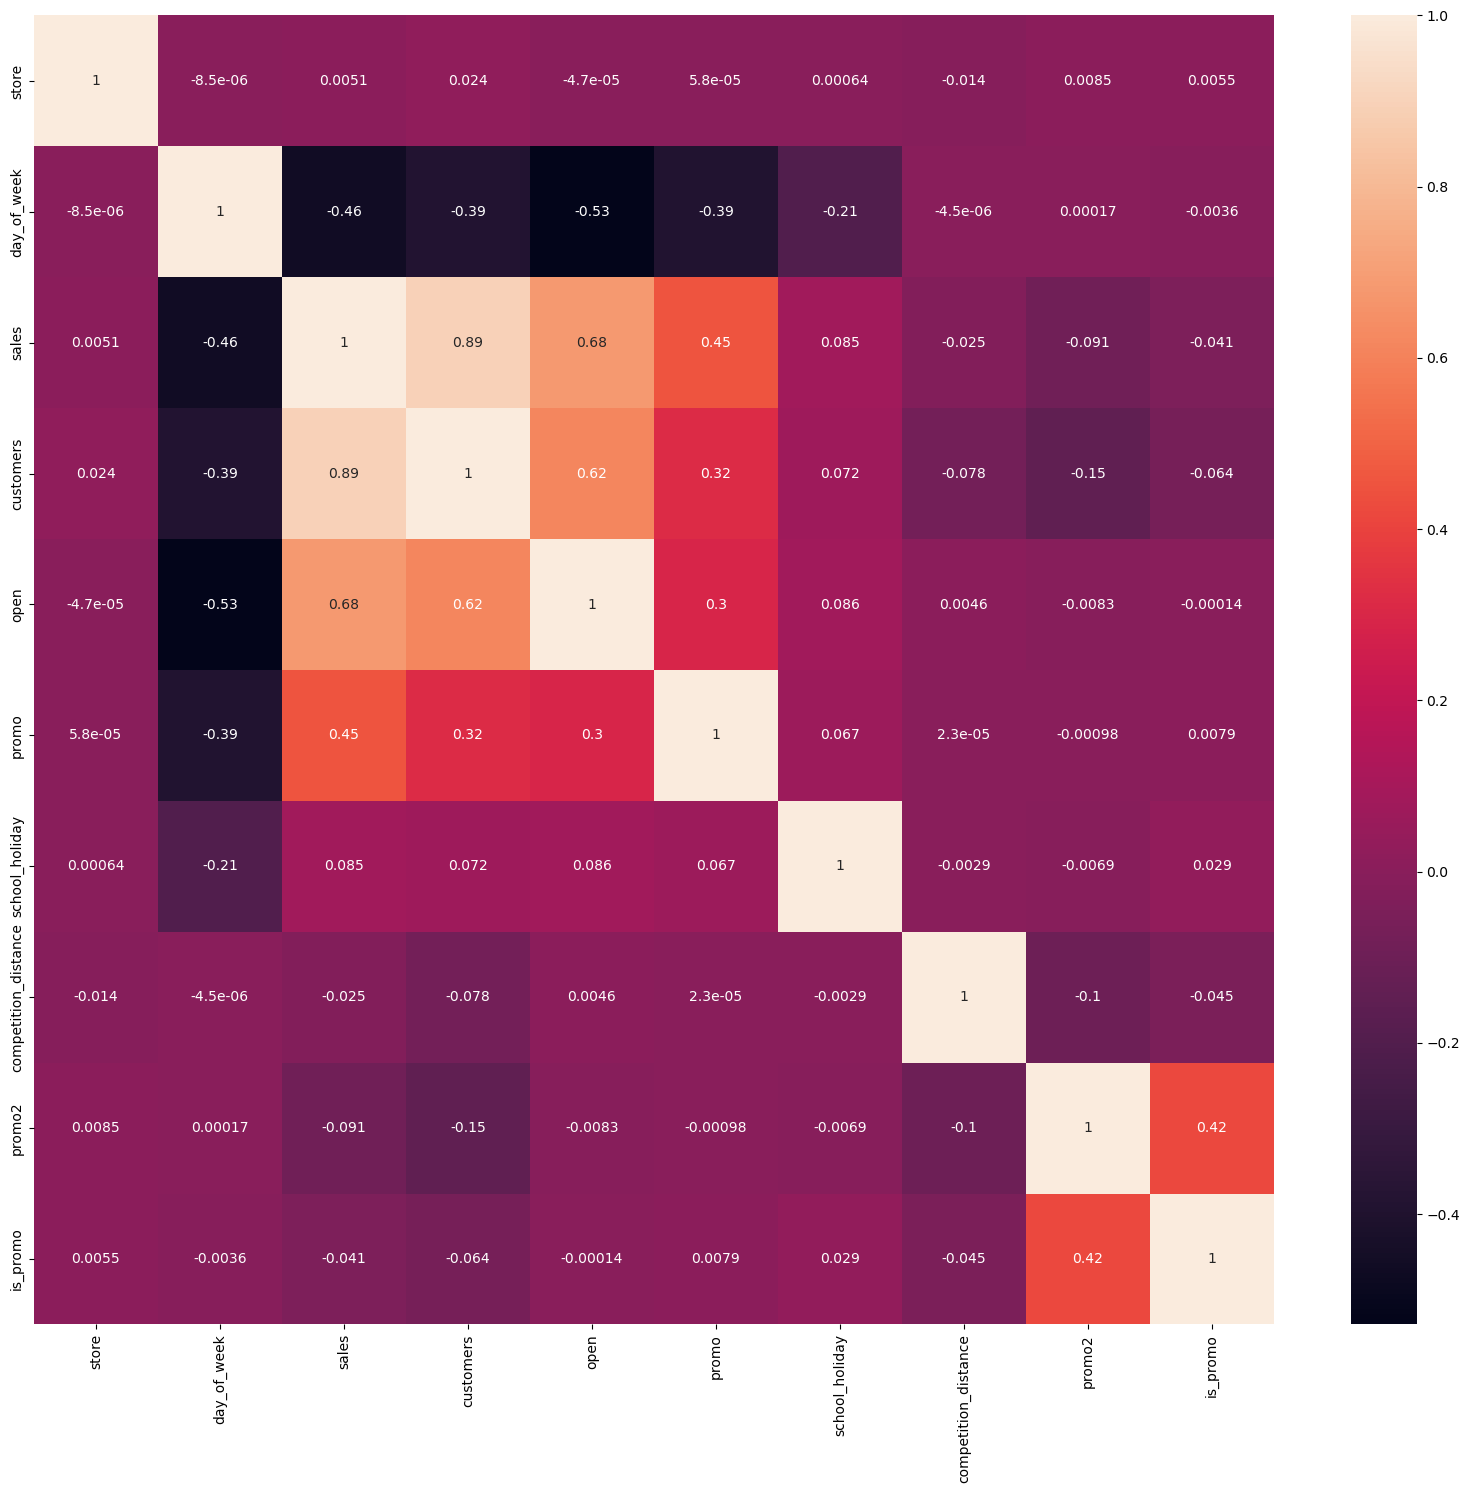

In [91]:
correlation = num_attributes.corr( method='pearson' )
sns.heatmap( correlation, annot=True );


##### 4.3.2 Categorical Attributes

In [93]:
import scipy.stats as ss

In [94]:
cm = pd.crosstab(a['state_holiday'], a['store_type'])

In [95]:
def cramer_v(x,y):
    cm = pd.crosstab(x, y).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max (0, chi2 - (k-1)*(r-1)/(n-1))
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    return np.sqrt((chi2corr/n)/(min(kcorr-1,rcorr-1)))


<Axes: >

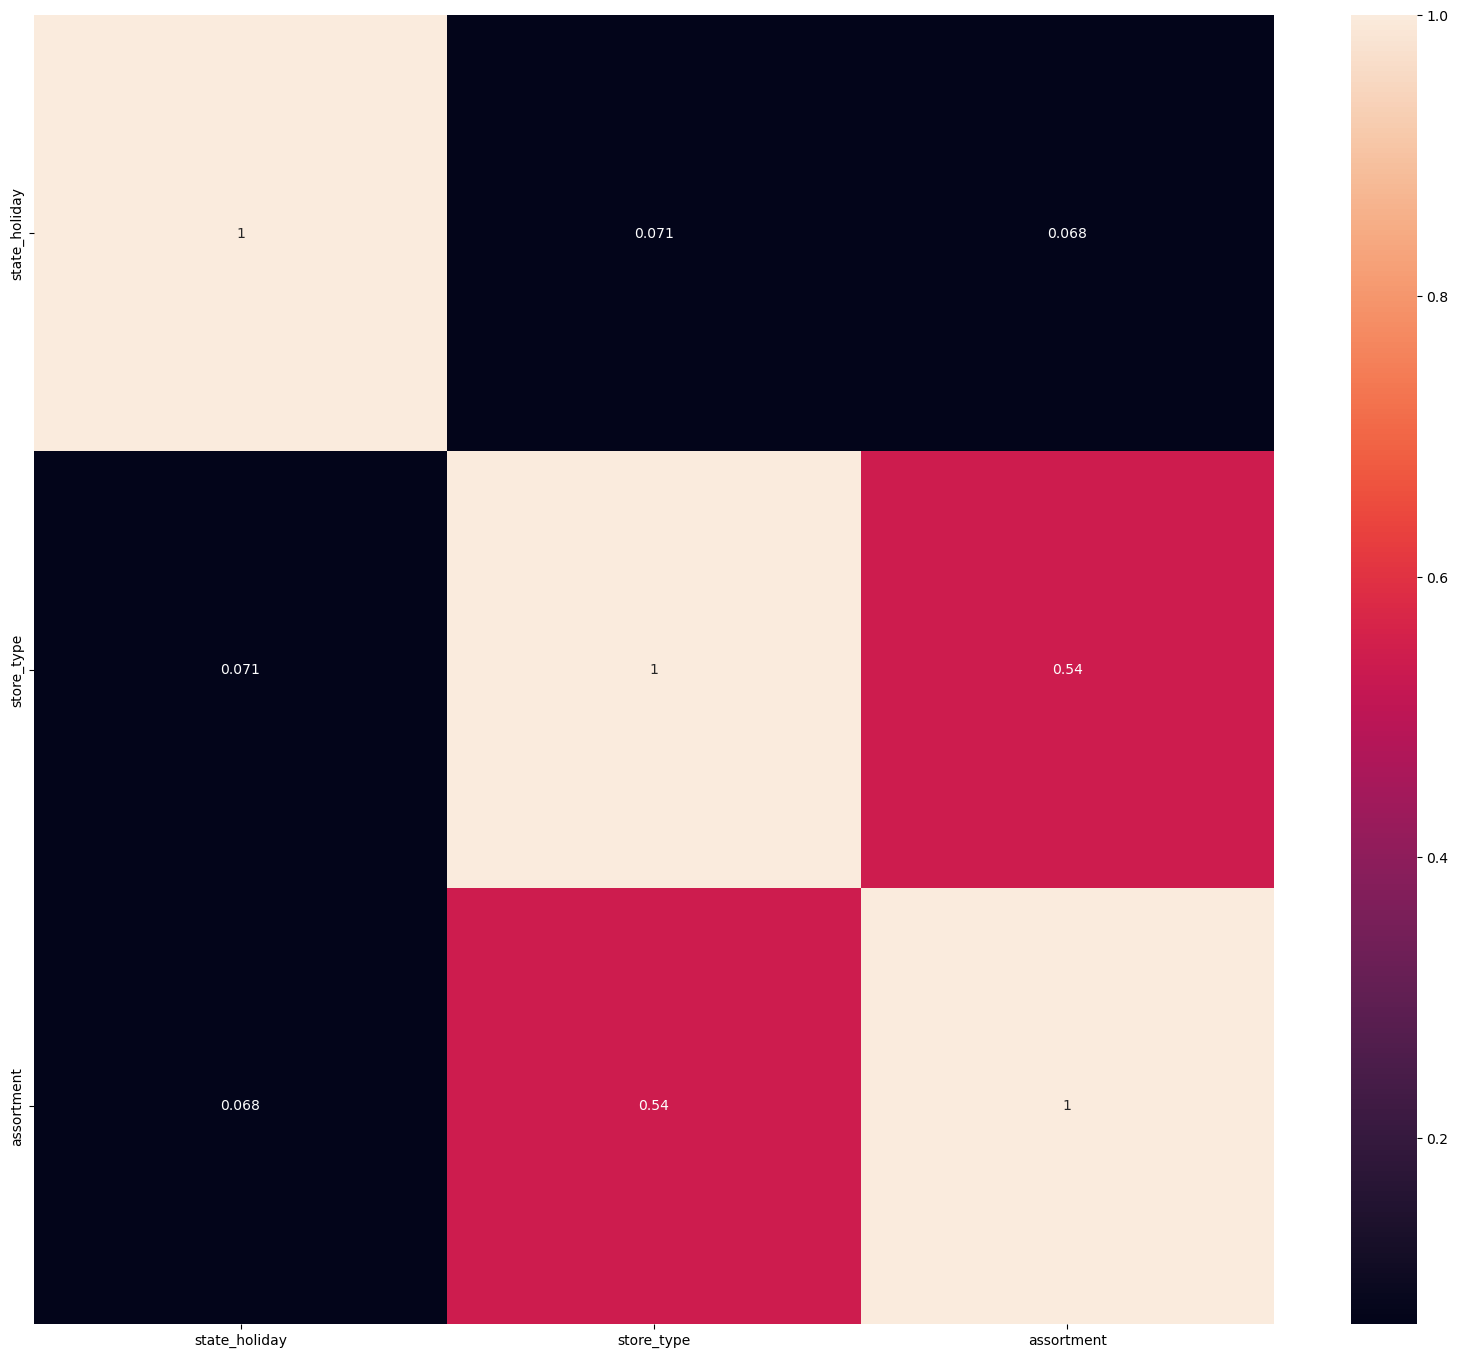

In [96]:
# only categorical data
a = df4.select_dtypes( include='object' )
# Calculate cramer V
a1 = cramer_v( a['state_holiday'], a['state_holiday'] )
a2 = cramer_v( a['state_holiday'], a['store_type'] )
a3 = cramer_v( a['state_holiday'], a['assortment'] )
a4 = cramer_v( a['store_type'], a['state_holiday'] )
a5 = cramer_v( a['store_type'], a['store_type'] )
a6 = cramer_v( a['store_type'], a['assortment'] )
a7 = cramer_v( a['assortment'], a['state_holiday'] )
a8 = cramer_v( a['assortment'], a['store_type'] )
a9 = cramer_v( a['assortment'], a['assortment'] )
# Final dataset
d = pd.DataFrame( {'state_holiday': [a1, a2, a3],
'store_type': [a4, a5, a6],
'assortment': [a7, a8, a9] })
d = d.set_index( d.columns )
sns.heatmap( d, annot=True )


### 5.0 - Data Preparation

In [98]:
df5 = df4.copy()

#### 5.1 - Normalização
##### Otimo para variaveis que possuem distribuição normal
- Não foi necessário fazer a normalização, porque as variaveis não tem distribuição normal.

### 5.2 - Rescaling

In [101]:
df5.select_dtypes(include = ['int64', 'float64'])

,store,day_of_week,sales,promo,school_holiday,competition_distance,promo2,is_promo
0,1,5,5263,1,1,1270.0,0,0
1,2,5,6064,1,1,570.0,1,1
2,3,5,8314,1,1,14130.0,1,1
3,4,5,13995,1,1,620.0,0,0
4,5,5,4822,1,1,29910.0,0,0
...,...,...,...,...,...,...,...,...
1016776,682,2,3375,0,1,150.0,0,0
1016827,733,2,10765,0,1,860.0,0,0
1016863,769,2,5035,0,1,840.0,1,1
1017042,948,2,4491,0,1,1430.0,0,0


<Axes: ylabel='promo_time_week'>

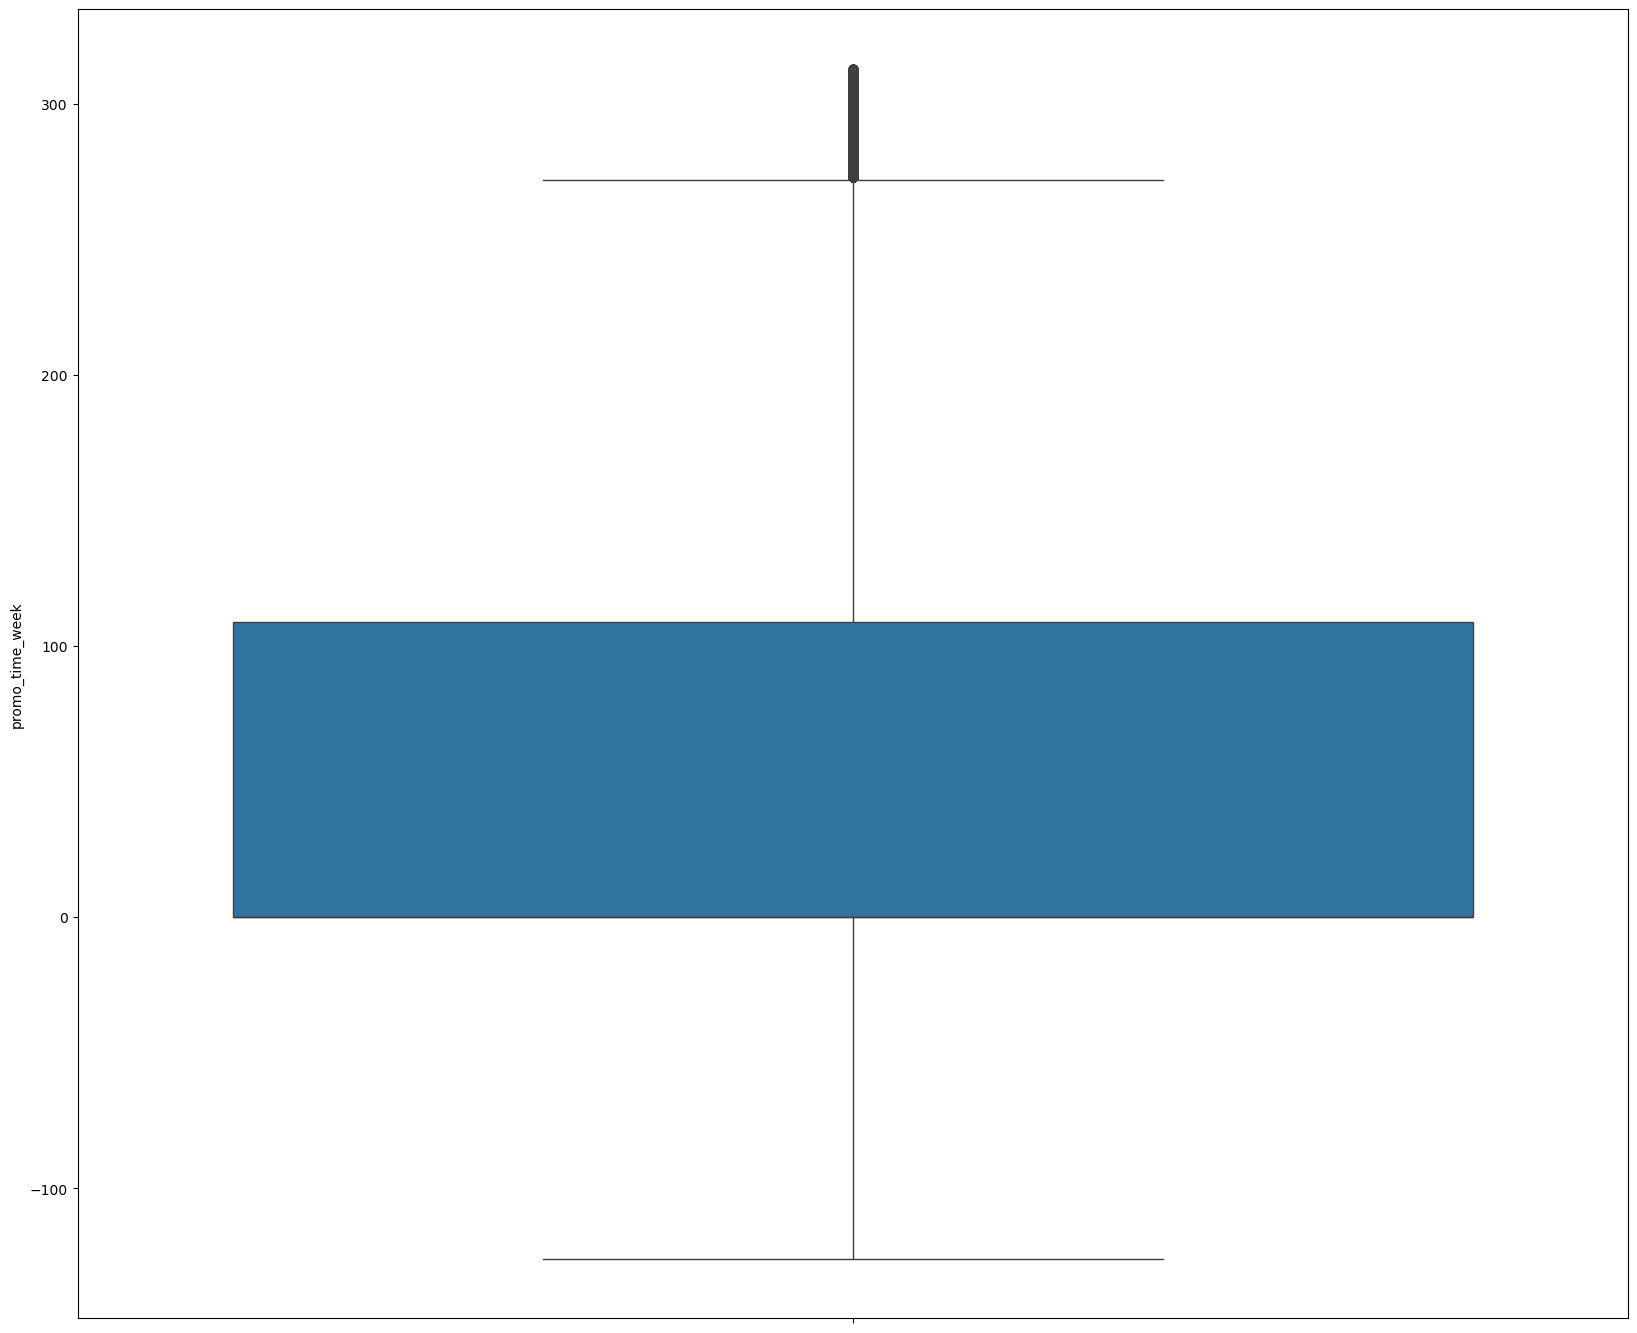

In [102]:
sns.boxplot(df5['promo_time_week'])

In [103]:
rs = RobustScaler()
mms = MinMaxScaler()

#competition distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
#competition time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
#promo time week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)
#year
df5['year'] = mms.fit_transform(df5[['year']].values)

#### 5.3 Encoding

In [105]:
#state holiday - One Hot Encoding
df5 = pd.get_dummies (df5, prefix=['state_holiday'], columns = ['state_holiday'])

In [106]:
#store_type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5 ['store_type'])

In [107]:
#assortment - Ordinal Encoding
assortment_dict = {'basic': 1,
                   'extra': 2,
                   'extended':3 }
df5['assortment'] = df5['assortment'].map(assortment_dict)

#### 5.3.2 Response Variable Transformation

In [109]:
df5['sales'] = np.log1p(df5['sales'])

#### 5.3.2 Nature Transformation

In [111]:
#day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi/7)))
#month  
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2. * np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2. * np.pi/12)))
#day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2. * np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2. * np.pi/30)))
#week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi/52)))

### 6.0 Feature Selection

In [113]:
df6 = df5.copy()

#### 6.1 Split dataframe into training and testing

In [115]:
cols_drop = ['week_of_year', 'day', 'month', 'day_of_week', 'promo_since', 'competition_since', 'year_week']

df6 = df6.drop(cols_drop, axis=1)

In [116]:
#training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

#test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print( 'Training Min Date: {}'.format( X_train['date'].min() ) )
print( 'Training Max Date: {}'.format( X_train['date'].max() ) )
print( '\nTest Min Date: {}'.format( X_test['date'].min() ) )
print( 'Test Max Date: {}'.format( X_test['date'].max() ) )

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date: 2015-06-19 00:00:00
Test Max Date: 2015-07-31 00:00:00


In [117]:
cols_selected_boruta = [
 'store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'day_of_week_sin',
 'day_of_week_cos',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'week_of_year_sin',
 'week_of_year_cos']
 # columns to add
feat_to_add = ['date', 'sales']
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

#### 7.0 ML Modeling

In [119]:
x_train = X_train[ cols_selected_boruta ]
x_test = X_test[ cols_selected_boruta ]
# Time Series Data Preparation
x_training = X_train[ cols_selected_boruta_full ]

#### 7.1 Average Model

In [121]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()
# prediction
aux2 = aux1[['store', 'sales']].groupby( 'store' ).mean().reset_index().rename(columns={'sales': 'predictions'} )
aux1 = pd.merge( aux1, aux2, how='left', on='store' )
yhat_baseline = aux1['predictions']
# performance
baseline_result = ml_error( 'Average Model', np.expm1( y_test ), np.expm1(yhat_baseline ) )
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


#### 7.2 Linear Regression Model

In [123]:
# model
lr = LinearRegression().fit( x_train, y_train )
# prediction

yhat_lr = lr.predict( x_test )
# performance

lr_result = ml_error( 'Linear Regression', np.expm1( y_test ), np.expm1(yhat_lr) )
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


#### 7.2.1 Cross Validation

In [125]:
lr_result_cv = cross_validation(x_training, 5, 'Linear Regression', lr, verbose=False)

lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


#### 7.3 Linear Regression Regularized Model - Lasso

In [127]:
lrr = Lasso (alpha=0.01).fit(x_train, y_train)

yhat_lrr = lrr.predict(x_test)

lrr_result = ml_error('Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr))

lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


#### 7.3.1 Lasso - Cross Validation

In [129]:
# lrr_result_cv = cross_validation( x_training, 5, 'Lasso', lrr, verbose=False )
# lrr_result_cv

In [130]:
rf = RandomForestRegressor(n_estimators = 100, n_jobs= -1, random_state=42).fit(x_train, y_train)

yhat_rf = rf.predict(x_test)

rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf))

rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.598831,0.099913,1011.119437


In [131]:
# rf_result_cv = cross_validation(x_training, 5, 'Random Forest Regressor', rf, verbose=True)

# rf_result_cv

In [132]:
model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                             n_estimators=100,
                             eta=0.01,
                             max_depth=10,
                             subsample=0.7,
                             colsample_bytee=0.9 ).fit( x_train, y_train )

yhat_xgb = model_xgb.predict(x_test)
xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))

xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,1695.785983,0.251783,2478.398037


In [133]:
xgb_result_cv = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True)
xgb_result_cv


KFold Number: 5

KFold Number: 4

KFold Number: 3

KFold Number: 2

KFold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1860.64 +/- 291.01,0.25 +/- 0.01,2685.39 +/- 429.0


#### 7.6 Comparing model performance

#### 7.6.1 Single performance

In [136]:
modelling_result = pd.concat( [baseline_result, lr_result, lrr_result,rf_result, xgb_result] )
modelling_result.sort_values( 'RMSE' )

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,679.598831,0.099913,1011.119437
0,Average Model,1354.800353,0.455051,1835.135542
0,XGBoost Regressor,1695.785983,0.251783,2478.398037
0,Linear Regression,1867.089774,0.292694,2671.049215
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


#### 7.6.2 Real Performance - Cross Validation

In [138]:
# modelling_result_cv = pd.concat( [lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv] )
# modelling_result_cv

#### 8.0 Hyperparameter finetunning

#### 8.1 Random Search

In [141]:
param = {
     'n_estimators': [1500, 1700, 2500, 3000, 3500],
     'eta': [0.01, 0.03],
     'max_depth': [3, 5, 9],
     'subsample': [0.1, 0.5, 0.7],
     'colsample_bytree': [0.3, 0.7, 0.9],
     'min_child_weight': [3, 8, 15]
}

MAX_EVAL = 5

In [142]:
# final_result = pd.DataFrame()

# for i in range( MAX_EVAL ):

#     hp = { k: random.sample( v, 1 )[0] for k, v in param.items() }
#     print( hp )
#     # model
#     model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
#                                 n_estimators=hp['n_estimators'],
#                                 eta=hp['eta'],
#                                 max_depth=hp['max_depth'],
#                                 subsample=hp['subsample'],
#                                 colsample_bytee=hp['colsample_bytree'],
#                                 min_child_weight=hp['min_child_weight'] )
#     result = cross_validation( x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True)
#     final_result = pd.concat([final_result, result])

In [143]:
# final_result

#### 8.2 Final Model

In [145]:
param_tuned = {
    'n_estimators': 3000,
    'eta': 0.03,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'min_child_weight': 3
}

In [146]:
model_xgb_tuned = xgb.XGBRegressor( objective='reg:squarederror',
                                    n_estimators=param_tuned['n_estimators'],
                                    eta=param_tuned['eta'],
                                    max_depth=param_tuned['max_depth'],
                                    subsample=param_tuned['subsample'],
                                    colsample_bytee=param_tuned['colsample_bytree'],
                                    min_child_weight=param_tuned['min_child_weight'] ).fit( x_train, y_train )
yhat_xgb_tuned = model_xgb_tuned.predict(x_test)

xgb_result_tuned = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned))

xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,769.902807,0.115168,1115.278073


In [147]:
mpe = mean_percentage_error( np.expm1( y_test ), np.expm1( yhat_xgb_tuned ) )
mpe

-0.018537723280796798

#### 9.0 - Tradução e interpretação do erro

In [232]:
df9 = X_test[cols_selected_boruta_full]

df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tuned)

#### 9.1 Business Performance

In [241]:
df91 = df9[['store', 'predictions']].groupby('store').sum().reset_index()

df9_aux1 = df9[['store','sales','predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns={0:'MAE'})
df9_aux2 = df9[['store','sales','predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index().rename(columns={0:'MAPE'})

df9_aux3 = pd.merge(df9_aux1, df9_aux2, how='inner', on='store')
df92 = pd.merge(df91, df9_aux3, how='inner', on='store')

df92['worst_scenario'] = df92['predictions']- df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE','MAPE']]


In [243]:
df92.sort_values('MAPE', ascending=False).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
291,292,107308.632812,103931.709473,110685.556152,3376.923340,0.604157
908,909,218559.093750,210519.178244,226599.009256,8039.915506,0.526616
594,595,303071.281250,296959.342787,309183.219713,6111.938463,0.422214
268,269,372361.750000,370050.540686,374672.959314,2311.209314,0.333740
875,876,194526.062500,190484.746264,198567.378736,4041.316236,0.317061


<Axes: xlabel='store', ylabel='MAPE'>

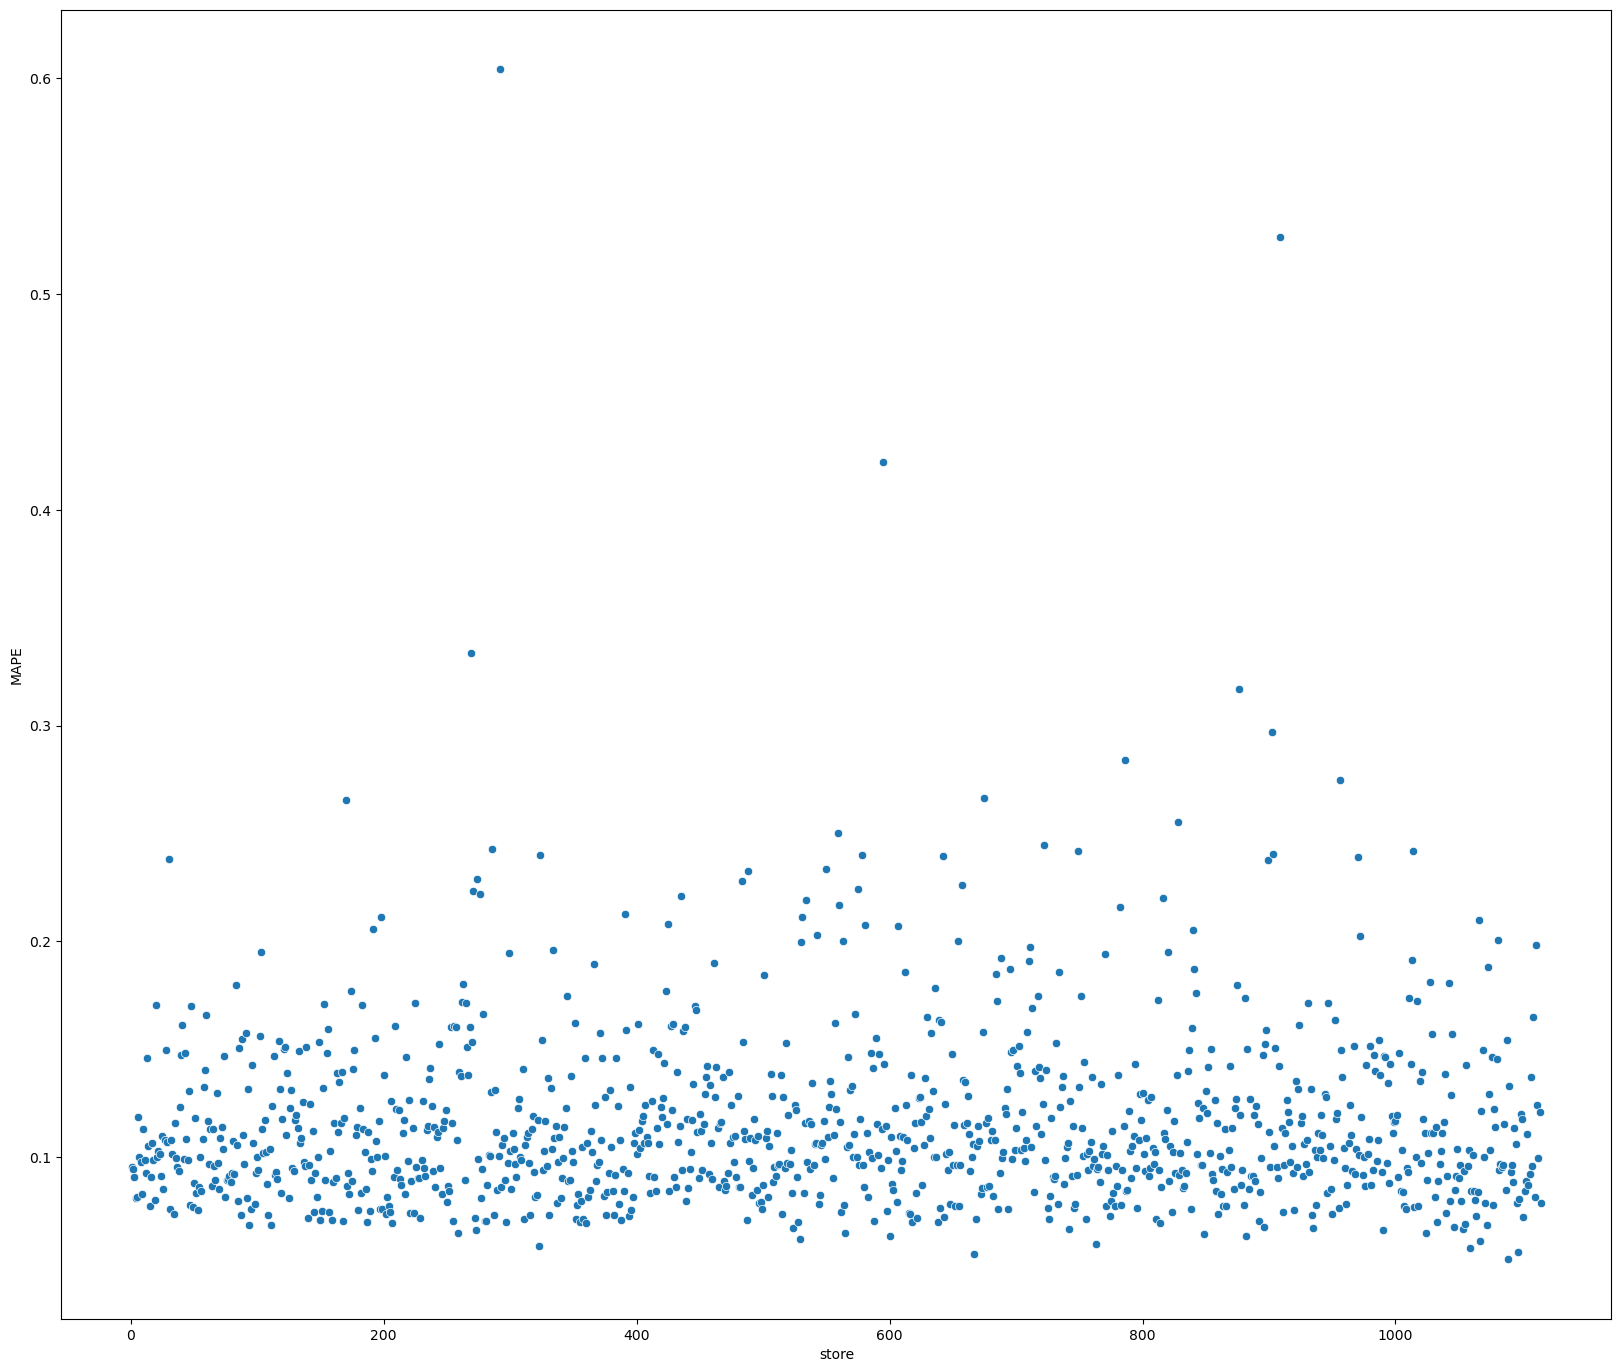

In [245]:
sns.scatterplot( x='store', y='MAPE', data=df92 )

#### 9.2 Total Performance

In [251]:
df93 = df92[['predictions', 'worst_scenario', 'best_scenario']].apply( lambda x:np.sum(x), axis=0).reset_index().rename(columns={'index': 'Scenario', 0:'Values'})

df93['Values'] = df93['Values'].map('R${:,.2f}'.format)
df93

,Scenario,Values
0,predictions,"R$287,038,848.00"
1,worst_scenario,"R$286,177,230.29"
2,best_scenario,"R$287,900,483.19"


#### 9.3 ML Performance

In [255]:
df9['error'] = df9['sales']- df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

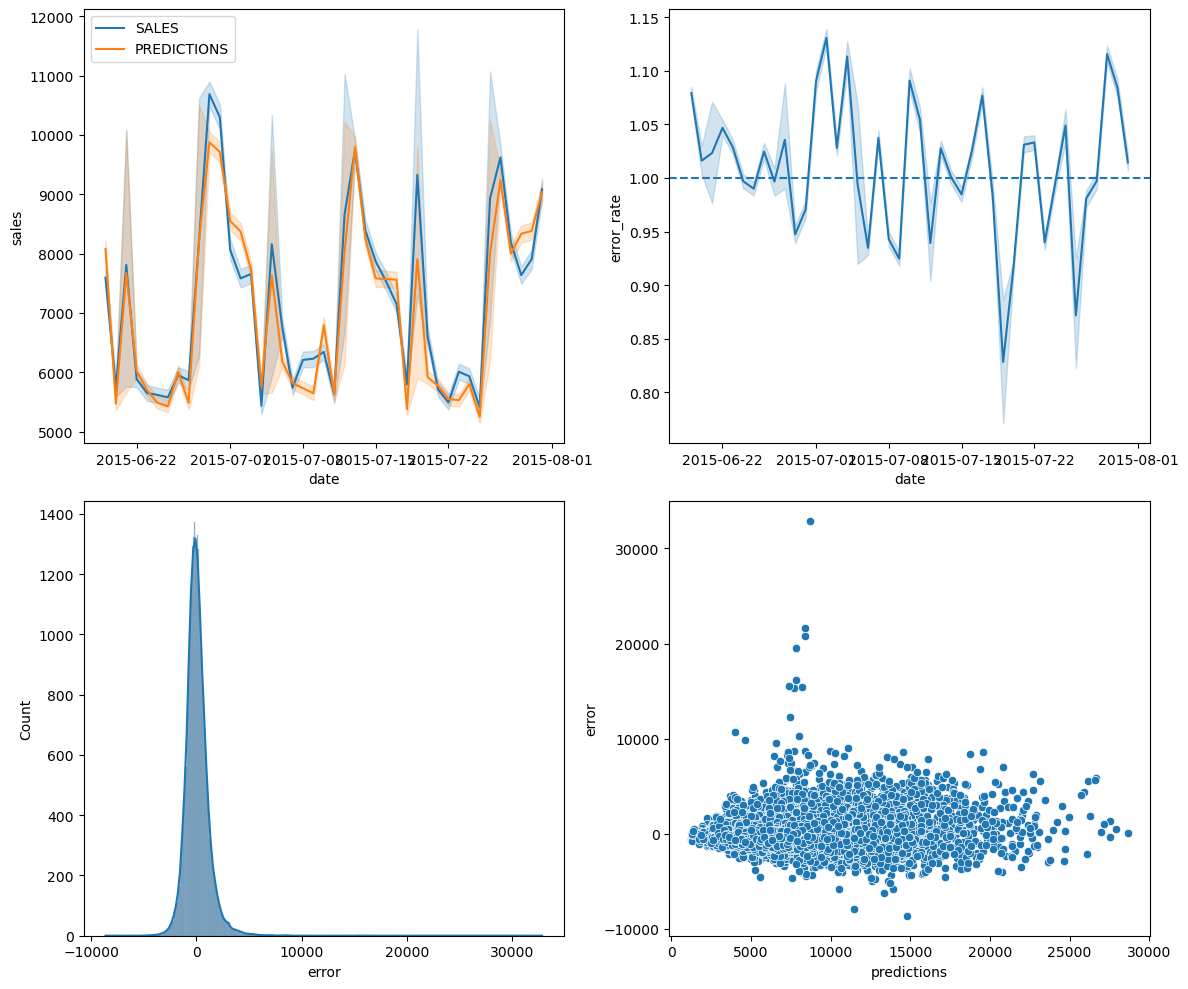

In [261]:
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
sns.lineplot(x='date', y='sales', data=df9, label='SALES')
sns.lineplot(x='date', y='predictions', data=df9, label='PREDICTIONS')

plt.subplot(2, 2, 2)
sns.lineplot(x='date', y='error_rate', data=df9)
plt.axhline(1, linestyle='--')

plt.subplot(2, 2, 3)
sns.histplot(df9['error'], kde=True) 

plt.subplot(2, 2, 4)
sns.scatterplot(x='predictions', y='error', data=df9) 

plt.tight_layout()
plt.show()